In [115]:
pip install scipy


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [116]:
pip install sympy


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [885]:
from sympy import combinatorics
from sympy.combinatorics import Permutation, PermutationGroup
from sympy.combinatorics import Polyhedron
from sympy.functions.combinatorial.numbers import stirling, bell
from itertools import permutations
from scipy.stats import chisquare
from numpy.polynomial import Polynomial
import random
import math
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Records count : expected and observable

In [118]:
def count_records_exp(k, n): 
    return stirling(n,k, kind=1) / math.factorial(n)

In [119]:
def gen_selection_for_permutation_group(N, n): 
    group = [Permutation(x) for x in permutations(range(n))]
    size = math.factorial(n)
    if N == size: 
        return group
    elif N < size: 
        return random.sample(group, N)
    else: 
        raise Exception('Incorrect selection size, N = {} should be less n = {}'.format(N, size))

In [120]:
def count_records(permutation: Permutation): 
    maximum = -1
    records = 0 
    for index, elem in enumerate(permutation.list()): 
         if elem > maximum: 
            records += 1
            maximum = elem    
    return records

In [122]:
def analyze_records(selection, n): 
    selection_size = len(selection)
    records_counts_ob, records_counts_exp = [0] * n, [0] * n
    
    length = math.factorial(n)
    for item in selection: 
        records_counts_ob[count_records(item) - 1] += 1
    for i in range(n): 
        records_counts_exp[i] = count_records_exp(i + 1, n) 
        
    (ob, exp) = np.array([float(i / selection_size) for i in records_counts_ob]), np.array([float(i) for i in records_counts_exp])
        
    return chisquare(f_obs=ob, f_exp=exp)

## Shortest cycle length : expected and observable

In [472]:
def expindex(x, M):
    res = x
    for i in range(2, M + 1):
        res += (x**i) / i
    return -res

def nthcoeff(f, x, n):
    res = sym.diff(f, x, n)
    return res.subs(x, 0) / math.factorial(n)

def get_polynom_for_cycle_length(M, n): 
    x = sym.Symbol('x')
    f = 1 - sym.exp(-x) if  M == 0 else sym.exp(expindex(x, M)) - sym.exp(expindex(x, M + 1))
    return nthcoeff(f / (1 - x), x, n)

def short_cycle_length(permutation):
    return min(permutation.cycle_structure.keys())

def get_sum_till_k(k):
    return -sum([1/i for i in range(1, k+1)])

def inf_short_cycle_length(k, n):
    if k == 0: 
        return 1 - exp(-1)
    elif k == (n-1):
        return 1 / n
    else: 
        return exp(get_sum_till_k(k)) - exp(get_sum_till_k(k+1))

In [364]:
def analyze_cycle_length(selection, n): 
    selection_size = len(selection)
    short_cycle_length_ob, short_cycle_length_exp = [0] * n, [0] * n

    length = math.factorial(n)
    for item in selection: 
        short_cycle_length_ob[short_cycle_length(item) - 1] += 1
    for i in range(math.floor(n / 2) + 1): 
        short_cycle_length_exp[i] = get_polynom_for_cycle_length(i, n) 
    short_cycle_length_exp[n-1] = get_polynom_for_cycle_length(n-1, n)
        
    (ob, exp) = np.array([float(i / selection_size) for i in short_cycle_length_ob]), np.array([float(i) for i in short_cycle_length_exp])
    ob = np.trim_zeros(np.sort(ob))
    exp = np.trim_zeros(np.sort(exp))
    
    return chisquare(f_obs=ob, f_exp=exp)

In [476]:
def form(array, n): 
    array = np.array([float(i) for i in array])
    return np.array(array)

def compare_formulas(n_1, n_2):
    inf, coef = [0] * n_2, [0] * n_1
    for i in range(math.floor(n_1 / 2)): 
        coef[i] = get_polynom_for_cycle_length(i, n_1) 
    for i in range(math.floor(n_2 / 2)): 
        inf[i] = inf_short_cycle_length(i, n_2)
    coef[n_1-1] = get_polynom_for_cycle_length(n_1-1, n_1)
    inf[n_2-1] = inf_short_cycle_length(n_2-1, n_2)
    
    inf = form(inf, n_2)
    coef = form(coef, n_1)
    
    return (inf, coef)

In [477]:
selection = gen_selection_for_permutation_group(2_000, 10)
analyze_cycle_length(selection, 10)

Power_divergenceResult(statistic=0.0005099288733220997, pvalue=0.9999999996877204)

### Only one graphic

### 3 x 3 graphics

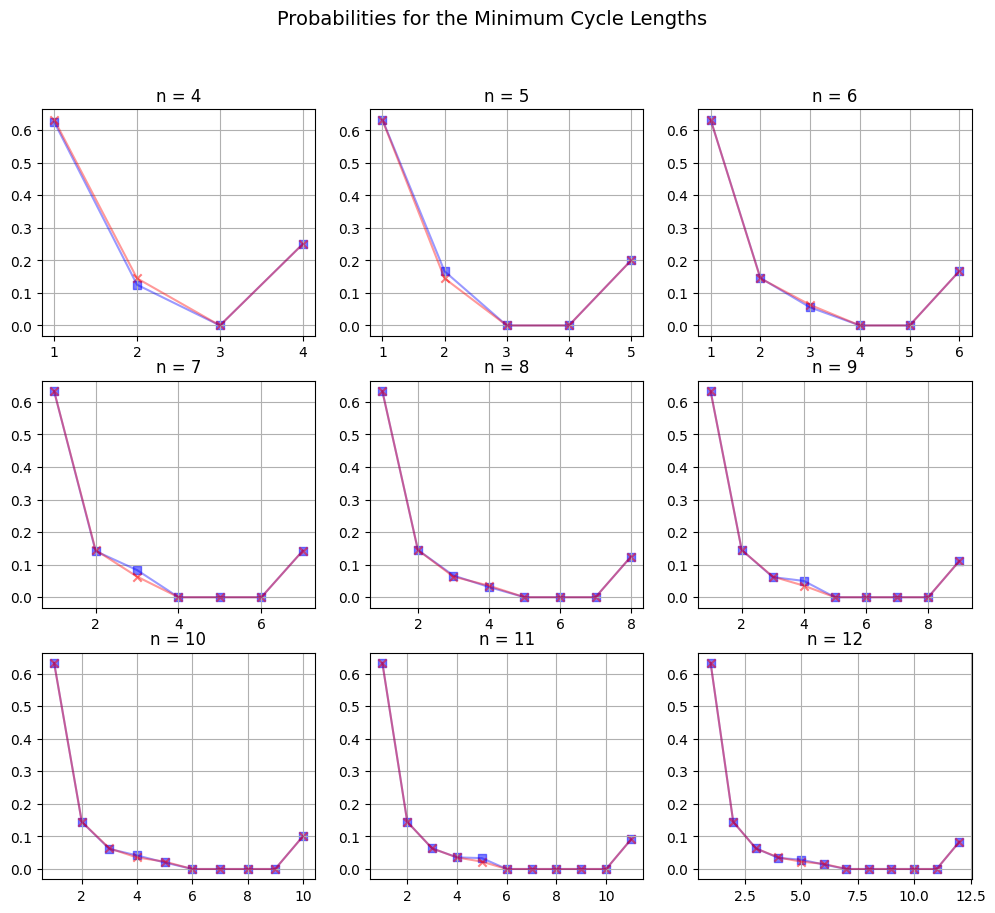

In [529]:
figure, axis = plt.subplots(3, 3, figsize=(12, 10))
figure.suptitle('Probabilities for the Minimum Cycle Lengths', fontsize=14)

for i in range(3):
    for j in range(3): 
        n = i*3 + j + 4
        (inf, coef) = compare_formulas(n, n)
        
        x = np.array([i for i in range(1, len(coef) + 1)]) 

        axis[i, j].scatter(x, coef, c='b', marker='s', label='Got \"n\" from coefficients', alpha=0.5)
        axis[i, j].plot(x, coef, c='b', alpha=0.4)
        
        axis[i, j].scatter(x, inf, c='r', marker='x', label='Limit of \"n\" to infinity', alpha=0.5)
        axis[i, j].plot(x, inf, c='r', alpha=0.4)
        
        axis[i, j].grid()
        axis[i, j].set_title("n = {}".format(n))
        #axis[i, j].axvspan(math.floor(n / 2) + 1, n-1, facecolor='0.1', alpha=0.1)

plt.show()

### Permutations generator

In [531]:
pip install bitarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 kB 697.0 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [897]:
import numpy as np
import operator
import sys
import random
import functools
import bitarray
from bitarray.util import int2ba
from tqdm import tqdm


def gen_permutation(f):
    res = np.empty(N)
    for el in range(N):
        res[el] = f(el)
    return res


def gen_quasigroup(f, phi, psy, pls):
    def g(x, y):
        return f(pls(phi(x), psy(y)))
    return g


def bijection(permutation):
    def f(x):
        return permutation[x]
    return f


def random_bijection(n):
    perm = np.random.permutation(n)
    return bijection(perm)


def left_shift(f, el):
    def g(x):
        return f(el, x)
    return g


def right_shift(f, el):
    def g(x):
        return f(x, el)
    return g


def multiple_left_shifts(*args, f):
    def g(x):
        res = x
        for el in args:
            res = f(el, x)
    return g


def multiple_right_shifts(*args, f):
    def g(x):
        res = x
        for el in args:
            res = f(x, el)
    return g


def pi():
    X = bitarray.bitarray([random.choice([True, False]) for _ in range(4)])
    def f(x, y):
        return X[2*x + y]
    return f


def good_pi():
    pi_funcs = [
                lambda x, y: x and y,
                lambda x, y: (x and y) ^ 1,
                lambda x, y: (x and y) ^ x,
                lambda x, y: (x and y) ^ y,
                lambda x, y: (x and y) ^ x ^ 1,
                lambda x, y: (x and y) ^ y ^ 1,
                lambda x, y: x ^ y,
                lambda x, y: x ^ y ^ 1,
                lambda x, y: (x and y) ^ x ^ y
            ]
    return pi_funcs[np.random.randint(0, 9)]


def quad_functions(args, i):
    ln = len(args)
    res = functools.reduce(lambda x, y: x != y, args[:i], False)
    res = functools.reduce(lambda x, y: x != y, [args[j] and args[k] for j in range(ln) for k in range(j) if (k != i and j != i)], res)
    return res


def triangle_functions(args, i):
    return random_bool_function(i - 1)(args[:i])


def random_bool_function(n: int): 
    N = 1 << n
    X = int2ba(random.randint(0, N-1), length = N)

    def f(args: bitarray.bitarray): 
        return X[sum([(1<<i) * el for i, el in enumerate(args)])]
    return f


def quasigroup_operation_quad(is_good_pi: bool = False):
    if not is_good_pi:
        rnd_fs = [good_pi() for _ in range(n)]
    else: 
        rnd_fs = [pi() for _ in range(n)]

    def f(x, y):
        X, Y = int2ba(x, length=n), int2ba(y, length=n)
        args = [f(x_i, y_i) for f, x_i, y_i in zip(rnd_fs, X, Y)]
        res = 0
        for i in range(n):
            res += (1 << (n - 1 - i)) * quad_functions(args, i)
        return res ^ x ^ y
    return f

def quasigroup_operation_triangle(is_good_pi: bool = False):
    if not is_good_pi:
        rnd_fs = [give_good_pi() for _ in range(n)]
    else: 
        rnd_fs = [give_pi() for _ in range(n)]

    family = [random_bool_function(i) for i in range(n)]

    def f(x, y):
        X, Y = int2ba(x, length=n), int2ba(y, length=n)
        args = [f(x_i, y_i) for f, x_i, y_i in zip(rnd_fs, X, Y)]
        res = 0
        for i in range(n):
            res += (1 << (n - 1 - i)) * family[i](args[:i])
        return res ^ x ^ y
    return f


def shuffle_arguments(f):
    shfl = bijection(np.random.permutation(ln))
    def g(args, i):
        ln = len(args)
        new_args = bitarray.bitarray(ln)
        for i in range(ln):
            new_args[i] = args[shfl(i)]
        return f(new_args, i)
    return g


n = 10
N = 1 << n


f_1, f_2, f_3 = [random_bijection(N) for _ in range(3)]
op = operator.xor
a = random.randint(0, N-1)
#print(gen_permutation(left_shift(gen_quasigroup(f_1, f_2, f_3, op), а)))
#print()

#print(gen_permutation(left_shift(quasigroup_operation_triangle(), а)))
#print()

#print(gen_permutation(left_shift(quasigroup_operation_quad(), а)))
#print()

#print(n)
#print(N)

permutations = []
for iteration in tqdm(range(500)):
    f1, f2, f3 = [random_bijection(N) for _ in range(3)]
    o = gen_quasigroup(f1, f2, f3, operator.xor)
    for _ in range(24):
        shift = left_shift(o, random.randint(0, N-1))
        permutations.append(Permutation(gen_permutation(shift))) ## Это записываем
        #print(p)


100%|█████████████████████████████████████████| 500/500 [00:13<00:00, 37.02it/s]


In [478]:
def compare_two_distr_graph(n): 
    (inf, coef) = compare_formulas(n, n)
    x = np.array([i for i in range(1, len(coef) + 1)])
    plt.scatter(x, inf, c='b', marker='x', label='Limit of \"n\" to infinity', alpha=0.5)
    plt.plot(x, inf, c='b', alpha=0.4)
    plt.scatter(x, coef, c='r', marker='s', label='Got \"n\" from coefficients', alpha=0.5)
    plt.plot(x, coef, c='r', alpha=0.4)
    plt.legend(loc='center')
    plt.xlabel('Minimal cycle lengths', fontsize=10, labelpad=18)
    plt.ylabel('Probability', fontsize=10, labelpad=18)
    plt.title('Probabilities for the minimum cycle lengths (n = {})'.format(n), fontsize=14)
    plt.grid()
    plt.show()

In [769]:
def gen_selection(n: int, N: int, is_bool_f:: 
    

SyntaxError: invalid syntax (3524683794.py, line 1)

In [844]:
pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sympy import subfactorial
from sympy.combinatorics import Permutation
import sympy.functions.combinatorial.numbers as math_num
import numpy as np
import math

ORDER_CONST: float = 1.1178641511899


# ===== Fixed points =====
def get_fixed_points(p_selection: list[Permutation]) -> tuple[list[int], list[int]]:
    n = p_selection[0].length()
    N = len(p_selection)
    o_fixed_points = [0] * (n + 1)
    e_fixed_points = [((1 / math.factorial(k)) * (subfactorial(n - k) / math.factorial(n - k))) * N for k in tqdm(range(n + 1))]

    for p in tqdm(p_selection):
        if 1 in p.cycle_structure.keys():
            o_fixed_points[p.cycle_structure[1]] += 1
        else:
            o_fixed_points[0] += 1
    return o_fixed_points, e_fixed_points

# ========================


# ===== Cycles count =====
def get_cycles_count(p_selection: list[Permutation]) -> tuple[list[int], list[int]]:
    n = p_selection[0].length()
    N = len(p_selection)
    o_cycles_count = [0] * n
    e_cycles_count = [(stirling(n, k, kind=1) / math.factorial(n)) * N for k in tqdm(range(1, n + 1))]
    for p in tqdm(p_selection):
        o_cycles_count[p.cycles - 1] += 1
    return o_cycles_count, e_cycles_count

# ========================


# ===== Records =====
def count_records(permutation: Permutation) -> int:
    maximum = -1
    records = 0
    for index, elem in enumerate(permutation.list()):
         if elem > maximum:
            records += 1
            maximum = elem
    return records


def count_records_exp(k, n):
    return math_num.stirling(n, k, kind=1) / math.factorial(n)


def get_records(p_selection: list[Permutation]) -> tuple[list, list]:
    n = p_selection[0].length()
    N = len(p_selection)
    o_records_counts, e_records_counts = [0] * n, [0] * n

    for p in p_selection:
        o_records_counts[count_records(p) - 1] += 1
    for i in range(n):
        e_records_counts[i] = count_records_exp(i + 1, n) * N

    return o_records_counts, e_records_counts

# ===================


# ===== Shortest cycle length =====
def sh_cycle_len(permutation):
    return min(permutation.cycle_structure.keys())


def get_sum_till_k(k):
    return -sum([1/i for i in range(1, k+1)])


def inf_short_cycle_length(k, n):
    if k == 0:
        return 1 - math.exp(-1)
    elif k == (n-1):
        return 1 / n
    else:
        return math.exp(get_sum_till_k(k)) - math.exp(get_sum_till_k(k+1))


def get_short_cycle_length(p_selection: list[Permutation]) -> tuple[np.array, np.array]:
    n = p_selection[0].length()
    o_short_cycle_length, e_short_cycle_length = [0] * (n + 2), [0] * n
    N = len(p_selection)

    for i in tqdm(range(math.floor(n / 2))):
        e_short_cycle_length[i] = inf_short_cycle_length(i, n) * N
    e_short_cycle_length[n-1] = inf_short_cycle_length(n - 1, n) * N

    for p in tqdm(p_selection):
        sc_len = sh_cycle_len(p) - 1
        o_short_cycle_length[sc_len] += 1
        
    o_sh_cl, e_sh_cl = [], []
    
    for scl in o_short_cycle_length: 
        if scl > 0.: 
            o_sh_cl.append(scl) 
            
    for scl in e_short_cycle_length: 
        if scl > 0.: 
            e_sh_cl.append(scl) 
        
    return o_sh_cl, e_sh_cl

# ===================


# ===== Permutation order =====
def order(p: Permutation) -> int:
    keys = list(p.cycle_structure.keys())
    lcm_r = keys[0]
    for k in keys[1:]: 
        lcm_r = np.lcm(lcm_r, k) 
    return lcm_r


def e_order(n: int) -> float:
    return 2**(ORDER_CONST * math.sqrt(n / math.log2(n)))


def get_permutation_orders(p_selection: list[Permutation]) -> tuple[float, float]:
    n = p_selection[0].length()
    o_permutation_orders = []
    e_ord = e_order(n)

    for p in p_selection:
        o_order = order(p)
        #print(o_order)
        o_permutation_orders.append(o_order)
        
    o_ord = sum(o_permutation_orders) / len(o_permutation_orders)

    return o_ord, e_ord

# ===========================


# ===== Parity =====

def get_permutation_parity(p_selection: list[Permutation]) -> tuple[float, float]:
    n = p_selection[0].length()
    o_parities = []

    for p in p_selection:
        o_parities.append(p.parity())

    o_parity = sum(o_parities) / len(o_parities)

    return o_parity, 1 / 2

# ==================


# ===== Inversions =====

def get_permutation_inversions(p_selection: list[Permutation]) -> tuple[float, float]:
    n = p_selection[0].length()
    o_inversions = []

    for p in p_selection:
        o_inversions.append(p.inversions())

    o_inv = sum(o_inversions) / len(o_inversions)

    return o_inv, (1024 * 1023) / 2

# ==================


In [1214]:
def conv(x, y, r=5): # x - O, y - E
    m = 0
    s = 0
    for i in range(len(x)):
        m += i*x[i]
        s += x[i]
    m = int(m/s) # the center of distr
    # print(m)
    left_x = [0 for k in range(m+1)] # should be croped
    left_y = [0 for k in range(m+1)] #
    # to the right
    i = 0
    k = 0
    while i <= m:
        s1 = x[i]
        s2 = y[i]
        if x[i] < r:
            while s1 < r:
                i += 1
                s1 += x[i]
                s2 += y[i]
        left_x[k] = s1
        left_y[k] = s2
        i += 1
        k += 1
    # to the left
    right_x = [0 for k in range(len(x) - m)]
    right_y = [0 for k in range(len(x) - m)]
    k = len(x) - m - 1
    i = len(x) - 1
    while i > m:
        s1 = x[i]
        s2 = y[i]
        if x[i] < r:
            while s1 < r:
                i -= 1
                s1 += x[i]
                s2 += y[i]
        right_x[k] = s1
        right_y[k] = s2
        i -= 1
        k -= 1
    
    while left_x[-1] == 0:
        left_x.pop()
        left_y.pop()
        
    while right_x[0] == 0:
        del right_x[0]
        del right_y[0]
    
    return (left_x + right_x, left_y + right_y)

def compare_two_distr_graph(ob, exp, name: str, r=0):
    selection_size = sum(ob)
    ob, exp = conv(ob, exp, 95)
    ob, exp = [float(x) for x in ob], [float(x) for x in exp]
    size = len(ob)
    x = [k for k in range(size)]
    
    obj = [str(i + 1) for i in x]
    obj[-1] = '>' + str(size)
    y_pos = np.arange(len(obj))

    df = pd.DataFrame()
    df['expected'] = exp
    df['observed'] = ob
    df['x'] = obj
    print(df)

    fig = plt.figure(figsize=(16, 8))
    plt.grid()
    plt.scatter(x, exp, c='b', marker='x', label='Expected', alpha=0.5)
    plt.plot(x, exp, c='b', alpha=0.4)
    plt.bar(y_pos, exp, align='center', color='b', alpha=0.2)   
    
    plt.scatter(x, ob,  c='r', marker='s', label='True', alpha=0.5)
    plt.plot(x, ob,  c='r', alpha=0.4)
    plt.bar(y_pos, ob, color='r', align='center', alpha=0.2)

    plt.legend()
    plt.xticks(y_pos, obj)
    plt.xlabel('Count of {}'.format(name), fontsize=10, labelpad=18)
    plt.ylabel('Frequency', fontsize=10, labelpad=18)
    plt.title('Histogram for {} (N = {}, n = 2^10)'.format(name, selection_size), fontsize=14)
    
    plt.show()

100%|█████████████████████████████████| 12000/12000 [00:00<00:00, 415857.49it/s]


      expected  observed   x
0  4414.553294    4448.0   1
1  4414.553294    4428.0   2
2  2207.276647    2155.0   3
3   735.758882     739.0   4
4   183.939721     187.0   5
5    36.787944      37.0   6
6     6.131324       5.0   7
7     0.998894       1.0  >8


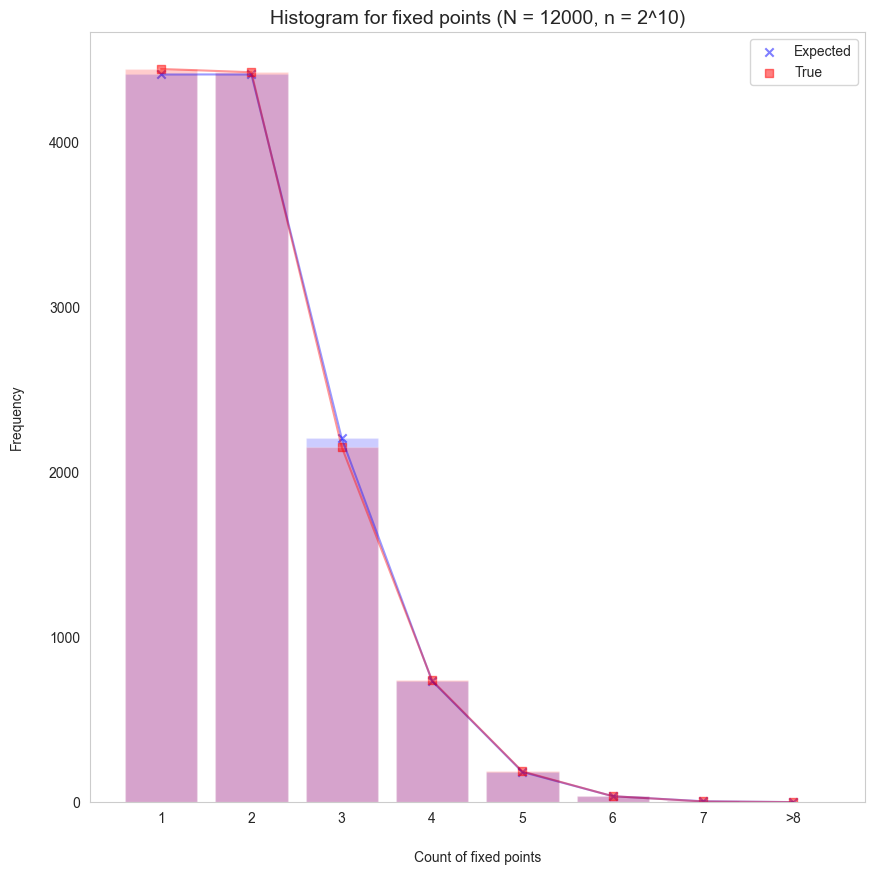

In [1164]:
o_fp, e_fp = get_fixed_points(permutations)
compare_two_distr_graph(o_fp, e_fp, "fixed points")

In [975]:
o_сс, e_сc = get_cycles_count(permutations)





  0%|                                                  | 0/1022 [00:00<?, ?it/s]



  2%|▋                                       | 17/1022 [00:00<00:06, 158.87it/s]



  3%|█▎                                      | 33/1022 [00:00<00:09, 100.15it/s]



  4%|█▊                                       | 45/1022 [00:00<00:13, 73.41it/s]



  5%|██▏                                      | 54/1022 [00:00<00:16, 59.99it/s]



  6%|██▍                                      | 61/1022 [00:00<00:18, 51.52it/s]



  7%|██▋                                      | 67/1022 [00:01<00:21, 45.01it/s]



  7%|██▉                                      | 72/1022 [00:01<00:23, 39.92it/s]



  8%|███                                      | 77/1022 [00:01<00:26, 35.96it/s]



  8%|███▏                                     | 81/1022 [00:01<00:28, 33.41it/s]



  8%|███▍                                     | 85/1022 [00:01<00:30, 30.93it/s]



  9%|███▌                                     | 89/1022 [00:01<00:32, 28

 23%|█████████▏                              | 235/1022 [00:13<01:22,  9.51it/s]



 23%|█████████▏                              | 236/1022 [00:13<01:22,  9.50it/s]



 23%|█████████▎                              | 237/1022 [00:13<01:22,  9.50it/s]



 23%|█████████▎                              | 238/1022 [00:13<01:22,  9.47it/s]



 23%|█████████▎                              | 239/1022 [00:13<01:22,  9.46it/s]



 23%|█████████▍                              | 240/1022 [00:13<01:23,  9.41it/s]



 24%|█████████▍                              | 241/1022 [00:13<01:23,  9.39it/s]



 24%|█████████▍                              | 242/1022 [00:13<01:23,  9.37it/s]



 24%|█████████▌                              | 243/1022 [00:13<01:23,  9.34it/s]



 24%|█████████▌                              | 244/1022 [00:14<01:23,  9.31it/s]



 24%|█████████▌                              | 245/1022 [00:14<01:24,  9.25it/s]



 24%|█████████▋                              | 246/1022 [00:14<01:25,  9.12i

 31%|████████████▌                           | 320/1022 [00:23<01:34,  7.44it/s]



 31%|████████████▌                           | 321/1022 [00:23<01:34,  7.40it/s]



 32%|████████████▌                           | 322/1022 [00:23<01:34,  7.37it/s]



 32%|████████████▋                           | 323/1022 [00:23<01:34,  7.37it/s]



 32%|████████████▋                           | 324/1022 [00:23<01:34,  7.37it/s]



 32%|████████████▋                           | 325/1022 [00:24<01:34,  7.35it/s]



 32%|████████████▊                           | 326/1022 [00:24<01:34,  7.35it/s]



 32%|████████████▊                           | 327/1022 [00:24<01:34,  7.34it/s]



 32%|████████████▊                           | 328/1022 [00:24<01:34,  7.32it/s]



 32%|████████████▉                           | 329/1022 [00:24<01:35,  7.27it/s]



 32%|████████████▉                           | 330/1022 [00:24<01:35,  7.24it/s]



 32%|████████████▉                           | 331/1022 [00:24<01:35,  7.21i

 40%|███████████████▊                        | 405/1022 [00:35<01:39,  6.22it/s]



 40%|███████████████▉                        | 406/1022 [00:36<01:39,  6.21it/s]



 40%|███████████████▉                        | 407/1022 [00:36<01:38,  6.23it/s]



 40%|███████████████▉                        | 408/1022 [00:36<01:38,  6.25it/s]



 40%|████████████████                        | 409/1022 [00:36<01:37,  6.27it/s]



 40%|████████████████                        | 410/1022 [00:36<01:38,  6.24it/s]



 40%|████████████████                        | 411/1022 [00:36<01:38,  6.22it/s]



 40%|████████████████▏                       | 412/1022 [00:37<01:38,  6.18it/s]



 40%|████████████████▏                       | 413/1022 [00:37<01:38,  6.17it/s]



 41%|████████████████▏                       | 414/1022 [00:37<01:38,  6.16it/s]



 41%|████████████████▏                       | 415/1022 [00:37<01:38,  6.15it/s]



 41%|████████████████▎                       | 416/1022 [00:37<01:38,  6.15i

 48%|███████████████████▏                    | 490/1022 [00:50<01:36,  5.49it/s]



 48%|███████████████████▏                    | 491/1022 [00:50<01:36,  5.49it/s]



 48%|███████████████████▎                    | 492/1022 [00:50<01:36,  5.47it/s]



 48%|███████████████████▎                    | 493/1022 [00:51<01:36,  5.47it/s]



 48%|███████████████████▎                    | 494/1022 [00:51<01:36,  5.49it/s]



 48%|███████████████████▎                    | 495/1022 [00:51<01:35,  5.52it/s]



 49%|███████████████████▍                    | 496/1022 [00:51<01:34,  5.54it/s]



 49%|███████████████████▍                    | 497/1022 [00:51<01:34,  5.56it/s]



 49%|███████████████████▍                    | 498/1022 [00:51<01:34,  5.54it/s]



 49%|███████████████████▌                    | 499/1022 [00:52<01:34,  5.54it/s]



 49%|███████████████████▌                    | 500/1022 [00:52<01:34,  5.53it/s]



 49%|███████████████████▌                    | 501/1022 [00:52<01:34,  5.51i

 56%|██████████████████████▌                 | 575/1022 [01:06<01:31,  4.91it/s]



 56%|██████████████████████▌                 | 576/1022 [01:06<01:30,  4.91it/s]



 56%|██████████████████████▌                 | 577/1022 [01:07<01:30,  4.89it/s]



 57%|██████████████████████▌                 | 578/1022 [01:07<01:30,  4.89it/s]



 57%|██████████████████████▋                 | 579/1022 [01:07<01:29,  4.96it/s]



 57%|██████████████████████▋                 | 580/1022 [01:07<01:28,  4.99it/s]



 57%|██████████████████████▋                 | 581/1022 [01:07<01:28,  4.97it/s]



 57%|██████████████████████▊                 | 582/1022 [01:08<01:28,  4.95it/s]



 57%|██████████████████████▊                 | 583/1022 [01:08<01:28,  4.94it/s]



 57%|██████████████████████▊                 | 584/1022 [01:08<01:28,  4.94it/s]



 57%|██████████████████████▉                 | 585/1022 [01:08<01:28,  4.93it/s]



 57%|██████████████████████▉                 | 586/1022 [01:08<01:28,  4.91i

 65%|█████████████████████████▊              | 660/1022 [01:24<01:14,  4.85it/s]



 65%|█████████████████████████▊              | 661/1022 [01:24<01:14,  4.86it/s]



 65%|█████████████████████████▉              | 662/1022 [01:24<01:14,  4.86it/s]



 65%|█████████████████████████▉              | 663/1022 [01:24<01:13,  4.86it/s]



 65%|█████████████████████████▉              | 664/1022 [01:24<01:13,  4.86it/s]



 65%|██████████████████████████              | 665/1022 [01:25<01:13,  4.87it/s]



 65%|██████████████████████████              | 666/1022 [01:25<01:13,  4.87it/s]



 65%|██████████████████████████              | 667/1022 [01:25<01:12,  4.87it/s]



 65%|██████████████████████████▏             | 668/1022 [01:25<01:12,  4.87it/s]



 65%|██████████████████████████▏             | 669/1022 [01:25<01:12,  4.86it/s]



 66%|██████████████████████████▏             | 670/1022 [01:26<01:12,  4.84it/s]



 66%|██████████████████████████▎             | 671/1022 [01:26<01:12,  4.82i

 73%|█████████████████████████████▏          | 745/1022 [01:42<00:59,  4.69it/s]



 73%|█████████████████████████████▏          | 746/1022 [01:42<00:58,  4.69it/s]



 73%|█████████████████████████████▏          | 747/1022 [01:42<00:58,  4.70it/s]



 73%|█████████████████████████████▎          | 748/1022 [01:42<00:58,  4.70it/s]



 73%|█████████████████████████████▎          | 749/1022 [01:43<00:57,  4.71it/s]



 73%|█████████████████████████████▎          | 750/1022 [01:43<00:57,  4.71it/s]



 73%|█████████████████████████████▍          | 751/1022 [01:43<00:57,  4.71it/s]



 74%|█████████████████████████████▍          | 752/1022 [01:43<00:57,  4.71it/s]



 74%|█████████████████████████████▍          | 753/1022 [01:43<00:57,  4.72it/s]



 74%|█████████████████████████████▌          | 754/1022 [01:44<00:56,  4.72it/s]



 74%|█████████████████████████████▌          | 755/1022 [01:44<00:56,  4.71it/s]



 74%|█████████████████████████████▌          | 756/1022 [01:44<00:56,  4.70i

 81%|████████████████████████████████▍       | 830/1022 [02:00<00:41,  4.59it/s]



 81%|████████████████████████████████▌       | 831/1022 [02:00<00:41,  4.59it/s]



 81%|████████████████████████████████▌       | 832/1022 [02:01<00:41,  4.60it/s]



 82%|████████████████████████████████▌       | 833/1022 [02:01<00:40,  4.61it/s]



 82%|████████████████████████████████▋       | 834/1022 [02:01<00:40,  4.61it/s]



 82%|████████████████████████████████▋       | 835/1022 [02:01<00:40,  4.62it/s]



 82%|████████████████████████████████▋       | 836/1022 [02:01<00:40,  4.60it/s]



 82%|████████████████████████████████▊       | 837/1022 [02:02<00:40,  4.59it/s]



 82%|████████████████████████████████▊       | 838/1022 [02:02<00:40,  4.56it/s]



 82%|████████████████████████████████▊       | 839/1022 [02:02<00:40,  4.56it/s]



 82%|████████████████████████████████▉       | 840/1022 [02:02<00:39,  4.56it/s]



 82%|████████████████████████████████▉       | 841/1022 [02:02<00:39,  4.56i

 90%|███████████████████████████████████▊    | 915/1022 [02:19<00:23,  4.60it/s]



 90%|███████████████████████████████████▊    | 916/1022 [02:19<00:23,  4.59it/s]



 90%|███████████████████████████████████▉    | 917/1022 [02:19<00:22,  4.60it/s]



 90%|███████████████████████████████████▉    | 918/1022 [02:20<00:22,  4.61it/s]



 90%|███████████████████████████████████▉    | 919/1022 [02:20<00:22,  4.61it/s]



 90%|████████████████████████████████████    | 920/1022 [02:20<00:22,  4.61it/s]



 90%|████████████████████████████████████    | 921/1022 [02:20<00:21,  4.62it/s]



 90%|████████████████████████████████████    | 922/1022 [02:21<00:21,  4.62it/s]



 90%|████████████████████████████████████▏   | 923/1022 [02:21<00:21,  4.62it/s]



 90%|████████████████████████████████████▏   | 924/1022 [02:21<00:21,  4.62it/s]



 91%|████████████████████████████████████▏   | 925/1022 [02:21<00:21,  4.61it/s]



 91%|████████████████████████████████████▏   | 926/1022 [02:21<00:20,  4.62i

 98%|██████████████████████████████████████▏| 1000/1022 [02:38<00:04,  4.44it/s]



 98%|██████████████████████████████████████▏| 1001/1022 [02:38<00:04,  4.45it/s]



 98%|██████████████████████████████████████▏| 1002/1022 [02:38<00:04,  4.44it/s]



 98%|██████████████████████████████████████▎| 1003/1022 [02:38<00:04,  4.45it/s]



 98%|██████████████████████████████████████▎| 1004/1022 [02:39<00:04,  4.48it/s]



 98%|██████████████████████████████████████▎| 1005/1022 [02:39<00:03,  4.51it/s]



 98%|██████████████████████████████████████▍| 1006/1022 [02:39<00:03,  4.52it/s]



 99%|██████████████████████████████████████▍| 1007/1022 [02:39<00:03,  4.50it/s]



 99%|██████████████████████████████████████▍| 1008/1022 [02:39<00:03,  4.52it/s]



 99%|██████████████████████████████████████▌| 1009/1022 [02:40<00:02,  4.52it/s]



 99%|██████████████████████████████████████▌| 1010/1022 [02:40<00:02,  4.54it/s]



 99%|██████████████████████████████████████▌| 1011/1022 [02:40<00:02,  4.55i

       expected  observed    x
0     11.741683       5.0    1
1     88.135927      76.0    2
2    321.133448     300.0    3
3    759.909464     727.0    4
4   1317.343068    1410.0    5
5   1788.368906    1735.0    6
6   1983.934675    2044.0    7
7   1852.588322    1790.0    8
8   1488.344835    1528.0    9
9   1046.166662    1021.0   10
10   652.025674     662.0   11
11   364.257806     341.0   12
12   184.054152     222.0   13
13    84.756975      77.0   14
14    35.803144      42.0   15
15    13.951641      14.0   16
16     5.039908       2.0   17
17     1.695099       3.0   18
18     0.748609       1.0  >19


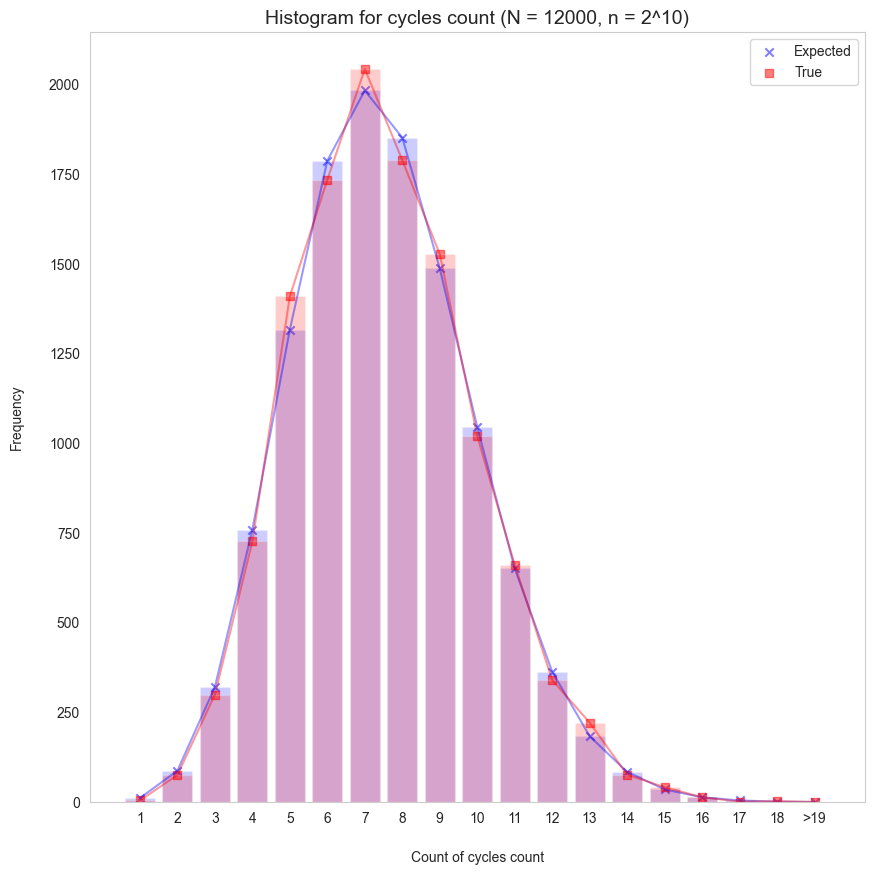

In [1132]:
compare_two_distr_graph(o_сс, e_сc, "cycles count")

In [994]:
o_r, e_r = get_records(permutations)





  0%|                                                 | 0/12000 [00:00<?, ?it/s]



 31%|██████████▉                        | 3769/12000 [00:00<00:00, 37684.29it/s]



100%|██████████████████████████████████| 12000/12000 [00:00<00:00, 41842.58it/s]




  0%|                                                  | 0/1022 [00:00<?, ?it/s]



100%|███████████████████████████████████████| 1022/1022 [00:12<00:00, 79.65it/s]


       expected  observed    x
0     11.741683      10.0    1
1     88.135927      92.0    2
2    321.133448     315.0    3
3    759.909464     700.0    4
4   1317.343068    1327.0    5
5   1788.368906    1828.0    6
6   1983.934675    2039.0    7
7   1852.588322    1844.0    8
8   1488.344835    1492.0    9
9   1046.166662    1059.0   10
10   652.025674     592.0   11
11   364.257806     382.0   12
12   184.054152     181.0   13
13    84.756975      77.0   14
14    35.803144      38.0   15
15    13.951641      15.0   16
16     5.039908       4.0   17
17     1.695099       4.0   18
18     0.748609       1.0  >19


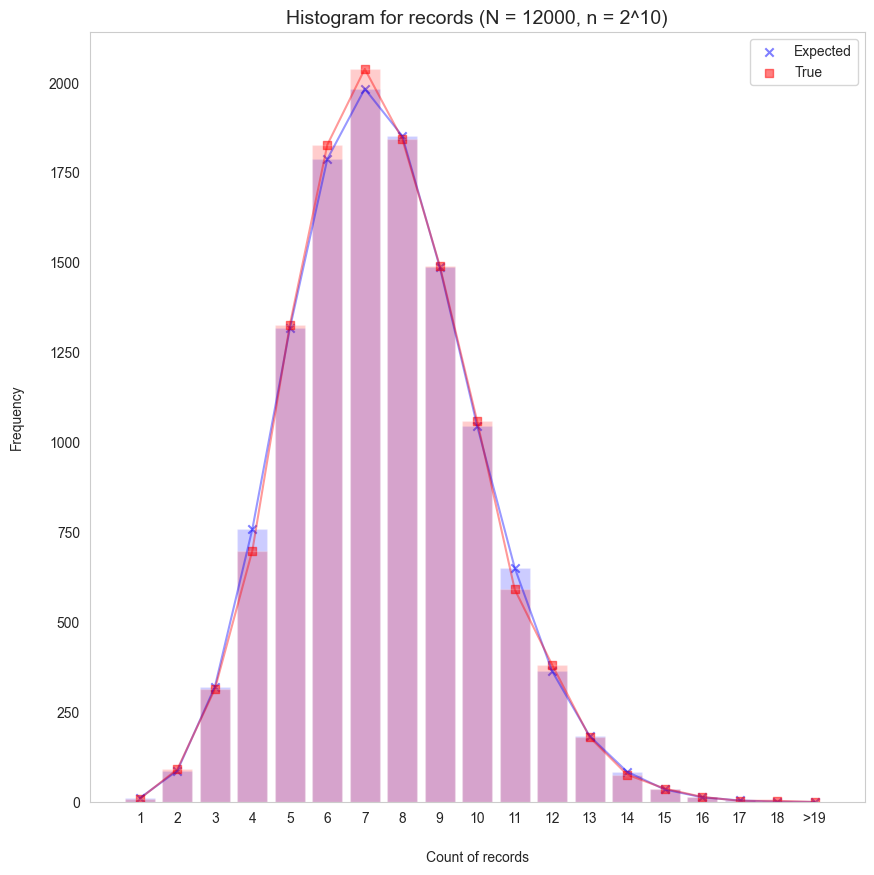

In [1133]:
compare_two_distr_graph(o_r, e_r, "records")

In [1074]:
o_sc, e_sc = get_short_cycle_length(permutations)

100%|█████████████████████████████████| 12000/12000 [00:00<00:00, 354640.53it/s]


       expected  observed    x
0   7585.446706    7552.0    1
1   1736.991372    1684.0    2
2    759.004969     791.0    3
3    424.383296     429.0    4
4    270.847734     261.0    5
5    187.802886     215.0    6
6    137.851002     166.0    7
7    105.479245     108.0    8
8    150.766886     154.0    9
9    142.464787     147.0   10
10   114.012677     117.0   11
11    85.528019      96.0   12
12   104.137002      95.0   13
13    95.469313      93.0   14
14    51.860373      92.0  >15


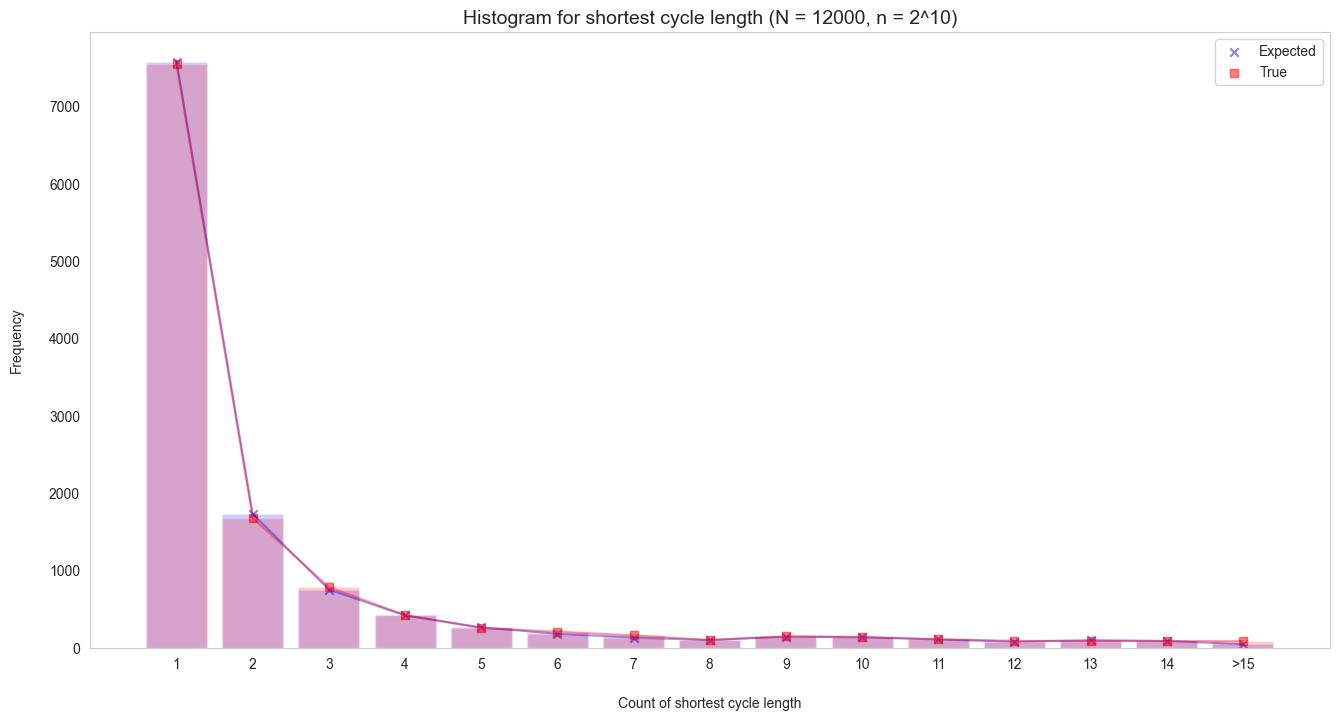

In [1141]:
compare_two_distr_graph(o_sc, e_sc, "shortest cycle length")

In [1144]:
o_ord, e_ord = get_permutation_orders(permutations)
print("ob: ", o_ord, "; exp:  ",  e_ord)

ob:  9217563183472.012 ; exp:   2542.425639659251


In [1109]:
o_prt, e_prt = get_permutation_parity(permutations)
print("ob: ", o_prt, "; exp:  ",  e_prt)

ob:  0.518 ; exp:   0.5


ob:  261842.956 ; exp:   523776.0


In [1155]:
permutations_2 = []

for iteration in tqdm(range(12000)):
    op = quasigroup_operation_quad()
    for i in range(1): ## Используем каждую операцию по одному разу
        shift = left_shift(op, random.randint(0, N - 1))
        permutations_2.append(Permutation(gen_permutation(shift)))

100%|█████████████████████████████████████| 12000/12000 [08:56<00:00, 22.35it/s]


100%|████████████████████████████████| 12000/12000 [00:00<00:00, 1770931.64it/s]


        expected  observed    x
0   4.414553e+03   10880.0    1
1   8.829107e+03   10880.0    2
2   2.943036e+03     173.0    3
3   2.277349e+02     351.0    4
4   1.229904e-01     315.0    5
5   2.241316e-10     182.0    6
6   1.730081e-32      81.0    7
7   3.533472e-86      14.0    8
8  1.153735e-212       3.0    9
9   0.000000e+00       1.0  >10


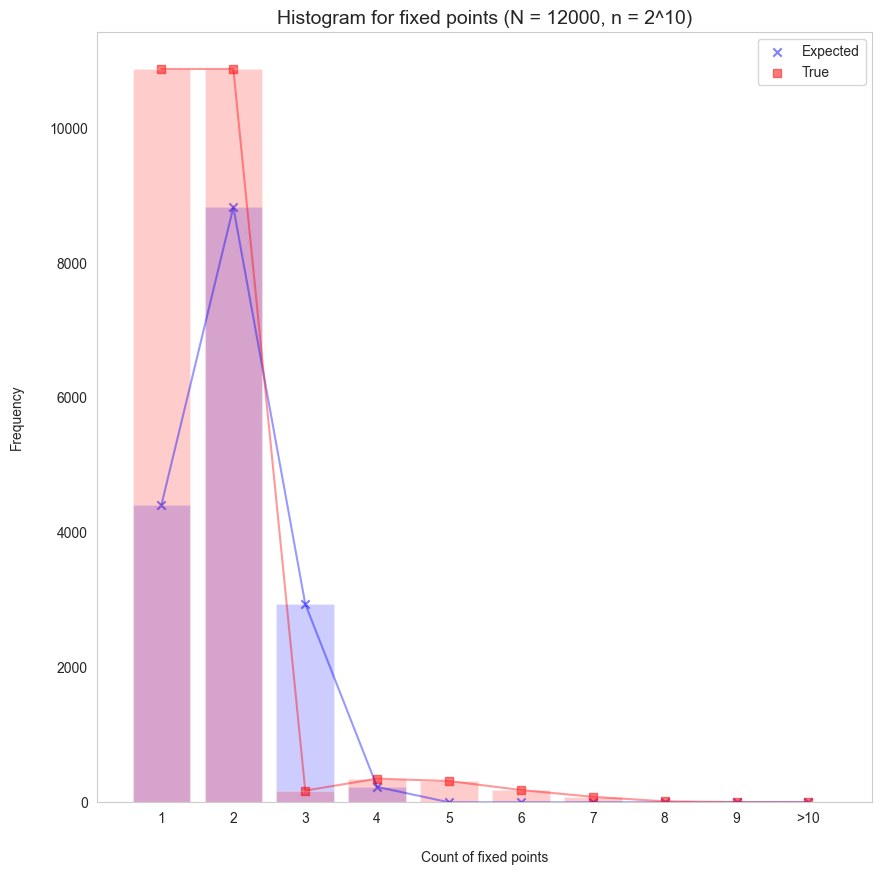

In [1161]:
o_fp_2, e_fp_2 = get_fixed_points(permutations_2)
compare_two_distr_graph(o_fp_2, e_fp_2, "fixed points")

In [1166]:
len(o_сс_2)

1024

In [1167]:
len(e_сc)

1022

         expected  observed    x
0    1.180921e+03     186.0    1
1    6.942235e+03     373.0    2
2    2.534511e+03     144.0    3
3    1.016283e+03     203.0    4
4    2.688111e+02     228.0    5
5    4.975479e+01    1146.0    6
6    6.735007e+00     132.0    7
7    6.899620e-01     105.0    8
8    5.497602e-02      61.0    9
9    3.484090e-03     571.0   10
10   1.789190e-04      59.0   11
11   7.563270e-06     318.0   12
12   2.667502e-07     122.0   13
13   7.941725e-09    2260.0   14
14   2.016404e-10      80.0   15
15   4.405622e-12     468.0   16
16   8.488194e-14     308.0   17
17   2.039223e-17     108.0   18
18   2.999777e-21     565.0   19
19   2.813329e-25      85.0   20
20   1.740239e-29     231.0   21
21   7.308770e-34    1203.0   22
22   9.401257e-33     246.0   23
23   6.786906e-42    1192.0   24
24   1.327555e-51      67.0   25
25   8.035082e-62     143.0   26
26   1.673901e-72      63.0   27
27   1.309728e-83     722.0   28
28   4.139845e-95      53.0   29
29  5.6226

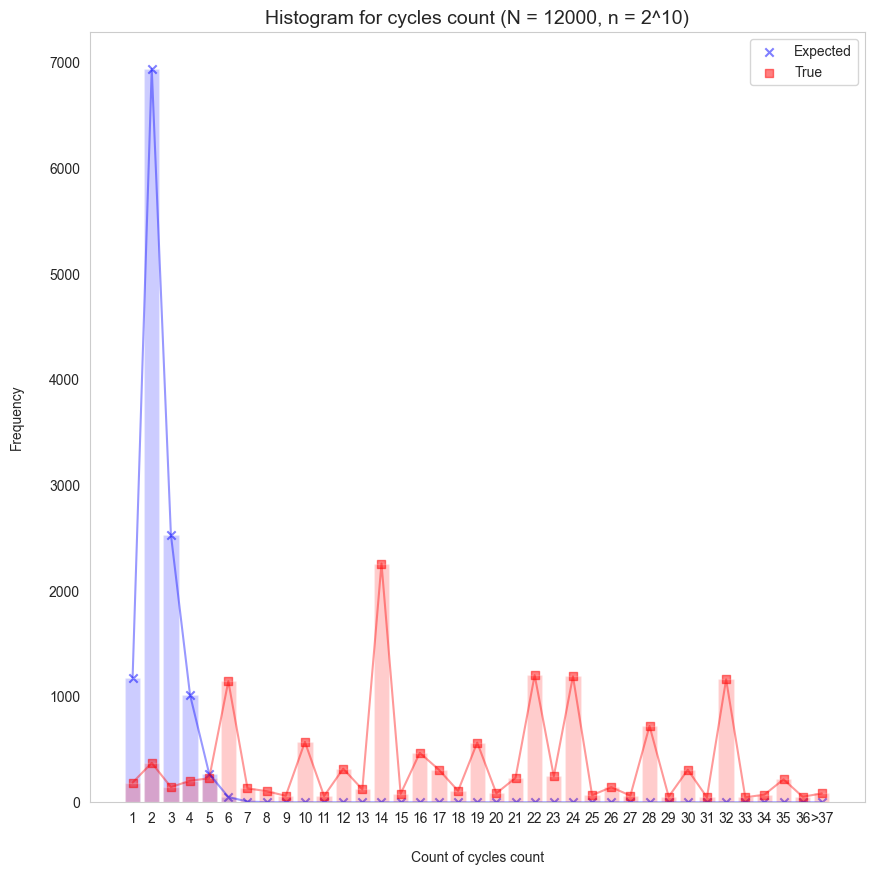

In [1174]:
#o_сс_2, e_сc_2 = get_cycles_count(permutations_2)
compare_two_distr_graph(o_сс_2[:-2], e_сc, "cycles count")

        expected  observed    x
0   9.970546e+01      92.0    1
1   3.206783e+02     116.0    2
2   7.590523e+02     241.0    3
3   1.316254e+03     286.0    4
4   1.787448e+03     435.0    5
5   1.983552e+03     399.0    6
6   1.852845e+03     602.0    7
7   1.489056e+03     518.0    8
8   1.047031e+03     590.0    9
9   6.527959e+02     477.0   10
10  3.648202e+02     631.0   11
11  1.844064e+02     502.0   12
12  8.495109e+01     618.0   13
13  3.589885e+01     462.0   14
14  1.399437e+01     573.0   15
15  5.057334e+00     417.0   16
16  1.701640e+00     476.0   17
17  5.351350e-01     343.0   18
18  1.578352e-01     441.0   19
19  4.379606e-02     319.0   20
20  1.146500e-02     374.0   21
21  2.838751e-03     239.0   22
22  6.663550e-04     333.0   23
23  1.486057e-04     212.0   24
24  3.154784e-05     251.0   25
25  6.386974e-06     178.0   26
26  1.235211e-06     191.0   27
27  2.285517e-07     130.0   28
28  4.051880e-08     155.0   29
29  6.892012e-09      90.0   30
30  1.12

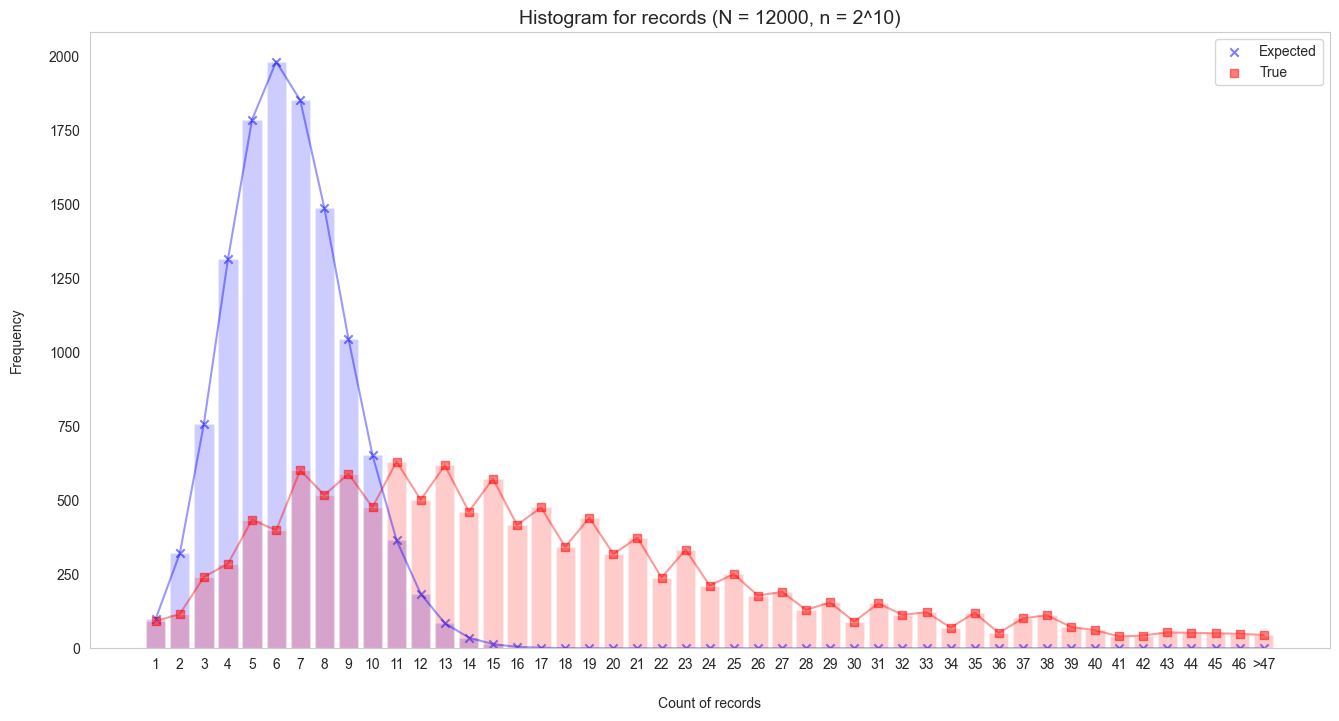

In [1184]:
#o_r_2, e_r_2 = get_records(permutations_2)
compare_two_distr_graph(o_r_2, e_r_2, "records")

100%|█████████████████████████████████| 12000/12000 [00:00<00:00, 500687.87it/s]


       expected  observed    x
0   7585.446706    1120.0    1
1   1736.991372    5148.0    2
2   1183.388264    1913.0    3
3    270.847734      84.0    4
4    187.802886      64.0    5
5    137.851002     514.0    6
6    105.479245      43.0    7
7    150.766886     155.0    8
8     55.739452     376.0    9
9     46.828903    1054.0   10
10   104.254565     587.0   11
11    49.654544     126.0   12
12    71.603941      58.0   13
13    38.363020     546.0   14
14    20.750757      75.0   15
15     9.243716     137.0  >16


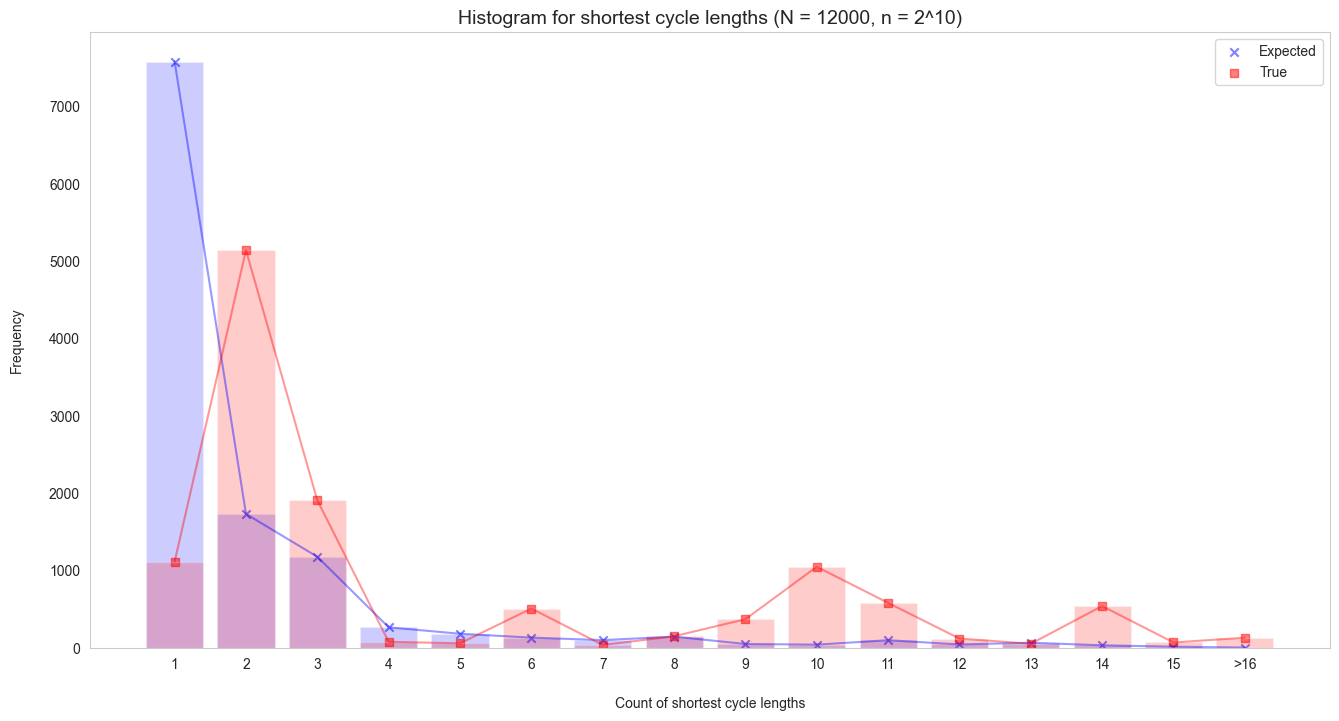

In [1185]:
o_sc_2, e_sc_2 = get_short_cycle_length(permutations_2)
compare_two_distr_graph(o_sc_2, e_sc_2, "shortest cycle lengths")

In [1186]:
o_ord_2, e_ord_2 = get_permutation_orders(permutations_2)
print("ob: ", o_ord_2, "; exp:  ",  e_ord_2)

ob:  3712335.2138333335 ; exp:   2542.425639659251


In [1187]:
o_prt_2, e_prt_2 = get_permutation_parity(permutations_2)
print("ob: ", o_prt_2, "; exp:  ",  e_prt_2)

ob:  0.0 ; exp:   0.5


In [1188]:
o_inv_2, e_inv_2 = get_permutation_inversions(permutations_2)
print("ob: ", o_inv_2, "; exp:  ",  e_inv_2)

ob:  262048.73316666667 ; exp:   523776.0


In [1194]:
permutations_3 = []

for iteration in tqdm(range(500)):
    f1, f2, f3 = [random_bijection(N) for _ in range(3)]
    o = gen_quasigroup(f1, f2, f3, lambda x, y: (x+y) % N)
    for _ in range(24):
        shift = left_shift(o, random.randint(0, N-1))
        permutations_3.append(Permutation(gen_permutation(shift))) ## Это записываем


100%|█████████████████████████████████████████| 500/500 [00:14<00:00, 35.61it/s]


100%|█████████████████████████████████████| 12000/12000 [03:18<00:00, 60.47it/s]


      expected  observed   x
0  4414.553294    4339.0   1
1  4414.553294    4448.0   2
2  2207.276647    2267.0   3
3   735.758882     734.0   4
4   183.939721     172.0   5
5    36.787944      32.0   6
6     6.131324       7.0   7
7     0.998894       1.0  >8


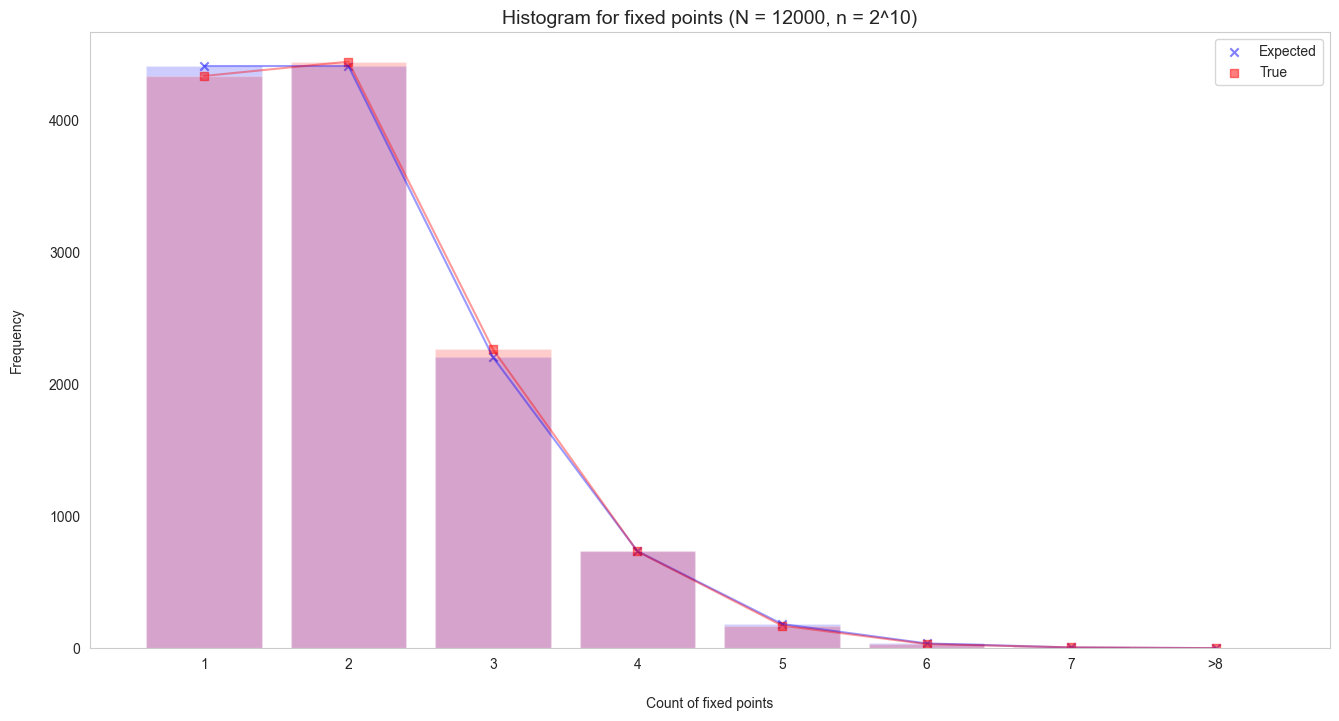

In [1196]:
o_fp_3, e_fp_3 = get_fixed_points(permutations_3)
compare_two_distr_graph(o_fp_3, e_fp_3, "fixed points")



  0%|                                                  | 0/1024 [00:00<?, ?it/s]

 45%|█████████████████                     | 461/1024 [00:00<00:00, 4607.25it/s]

100%|███████████████████████████████████████| 1024/1024 [00:22<00:00, 45.47it/s]


  0%|                                                 | 0/12000 [00:00<?, ?it/s]

  5%|█▉                                   | 643/12000 [00:00<00:01, 6428.78it/s]

 11%|███▊                                | 1290/12000 [00:00<00:01, 6448.29it/s]

 16%|█████▊                              | 1940/12000 [00:00<00:01, 6468.05it/s]

 22%|███████▊                            | 2587/12000 [00:00<00:01, 6433.27it/s]

 27%|█████████▋                          | 3231/12000 [00:00<00:01, 6345.29it/s]

 32%|███████████▌                        | 3866/12000 [00:00<00:01, 6294.33it/s]

 37%|█████████████▍                      | 4496/12000 [00:00<00:01, 6193.77it/s]

 43%|███████████████▍                    | 5142/12000 [00:00<00:01, 6276.03it/s]

 48%|████████

       expected  observed    x
0     11.718750       9.0    1
1     87.986708      79.0    2
2    320.678302     319.0    3
3    759.052257     753.0    4
4   1316.253912    1301.0    5
5   1787.448401    1764.0    6
6   1983.552261    2053.0    7
7   1852.844671    1819.0    8
8   1489.056373    1536.0    9
9   1047.030639    1044.0   10
10   652.795903     639.0   11
11   364.820229     378.0   12
12   184.406387     176.0   13
13    84.951087      72.0   14
14    35.898852      38.0   15
15    13.994367      11.0   16
16     5.057334       5.0   17
17     1.701640       3.0   18
18     0.751924       1.0  >19


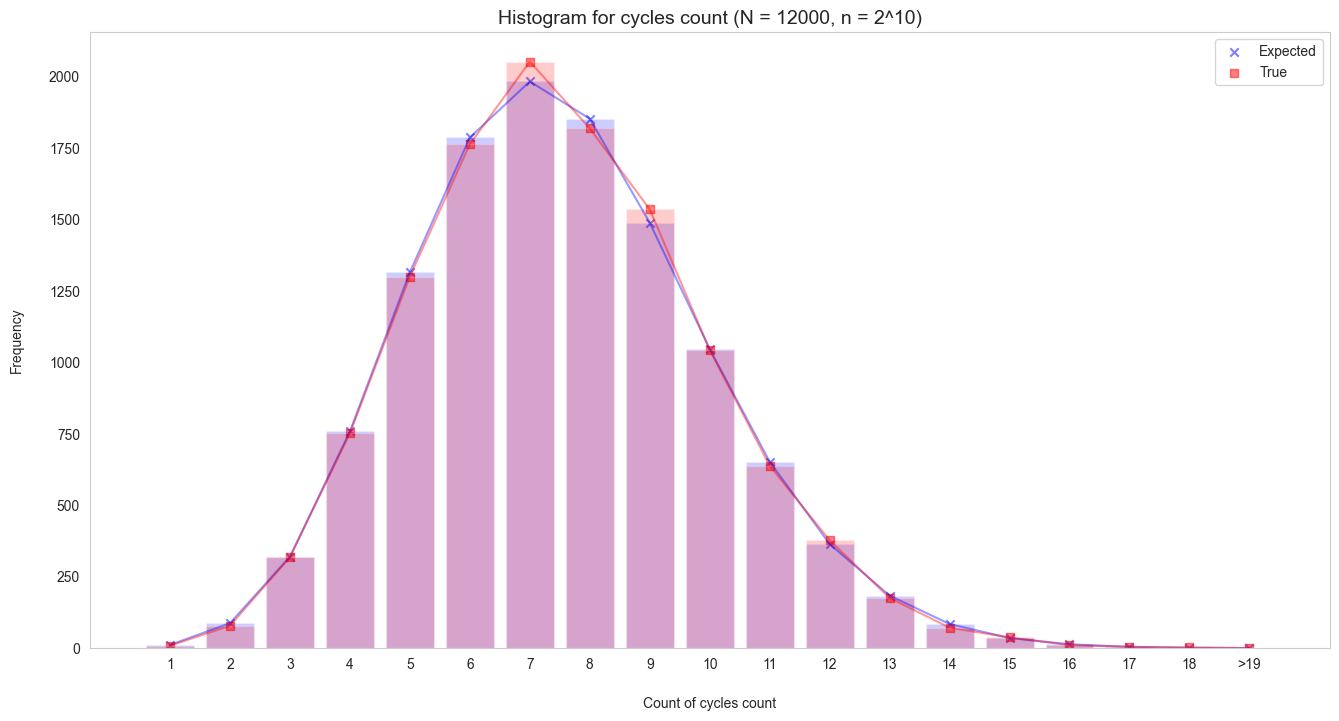

In [1199]:
o_сс_3, e_сc_3 = get_cycles_count(permutations_3)
compare_two_distr_graph(o_сс_3, e_сc_3, "cycles count")



  0%|                                                 | 0/12000 [00:00<?, ?it/s]

 25%|████████▌                          | 2944/12000 [00:00<00:00, 29437.08it/s]

 50%|█████████████████▍                 | 5994/12000 [00:00<00:00, 30034.06it/s]

100%|██████████████████████████████████| 12000/12000 [00:00<00:00, 29092.60it/s]


  0%|                                                  | 0/1024 [00:00<?, ?it/s]

  2%|▋                                       | 18/1024 [00:00<00:05, 176.87it/s]

  4%|█▍                                       | 36/1024 [00:00<00:10, 96.78it/s]

  5%|█▉                                       | 48/1024 [00:00<00:14, 69.26it/s]

  6%|██▎                                      | 57/1024 [00:00<00:17, 56.56it/s]

  6%|██▌                                      | 64/1024 [00:01<00:19, 48.36it/s]

  7%|██▊                                      | 70/1024 [00:01<00:22, 42.00it/s]

  7%|███                                      | 75/1024 [00:01<00:24, 38.10it/s]

  8%|███▏    

 23%|█████████▍                              | 240/1024 [00:13<01:23,  9.41it/s]

 24%|█████████▍                              | 241/1024 [00:13<01:23,  9.38it/s]

 24%|█████████▍                              | 242/1024 [00:13<01:23,  9.37it/s]

 24%|█████████▍                              | 243/1024 [00:13<01:23,  9.31it/s]

 24%|█████████▌                              | 244/1024 [00:14<01:24,  9.25it/s]

 24%|█████████▌                              | 245/1024 [00:14<01:24,  9.20it/s]

 24%|█████████▌                              | 246/1024 [00:14<01:24,  9.19it/s]

 24%|█████████▋                              | 247/1024 [00:14<01:25,  9.07it/s]

 24%|█████████▋                              | 248/1024 [00:14<01:26,  8.95it/s]

 24%|█████████▋                              | 249/1024 [00:14<01:27,  8.89it/s]

 24%|█████████▊                              | 250/1024 [00:14<01:27,  8.87it/s]

 25%|█████████▊                              | 251/1024 [00:14<01:27,  8.83it/s]

 25%|█████████▊ 

 33%|█████████████                           | 333/1024 [00:25<01:35,  7.23it/s]

 33%|█████████████                           | 334/1024 [00:25<01:35,  7.23it/s]

 33%|█████████████                           | 335/1024 [00:25<01:35,  7.24it/s]

 33%|█████████████▏                          | 336/1024 [00:25<01:34,  7.25it/s]

 33%|█████████████▏                          | 337/1024 [00:25<01:34,  7.25it/s]

 33%|█████████████▏                          | 338/1024 [00:25<01:35,  7.21it/s]

 33%|█████████████▏                          | 339/1024 [00:26<01:35,  7.15it/s]

 33%|█████████████▎                          | 340/1024 [00:26<01:36,  7.06it/s]

 33%|█████████████▎                          | 341/1024 [00:26<01:37,  7.03it/s]

 33%|█████████████▎                          | 342/1024 [00:26<01:36,  7.06it/s]

 33%|█████████████▍                          | 343/1024 [00:26<01:36,  7.08it/s]

 34%|█████████████▍                          | 344/1024 [00:26<01:35,  7.09it/s]

 34%|███████████

 42%|████████████████▋                       | 426/1024 [00:39<01:39,  5.99it/s]

 42%|████████████████▋                       | 427/1024 [00:39<01:41,  5.88it/s]

 42%|████████████████▋                       | 428/1024 [00:39<01:43,  5.79it/s]

 42%|████████████████▊                       | 429/1024 [00:40<01:42,  5.79it/s]

 42%|████████████████▊                       | 430/1024 [00:40<01:41,  5.83it/s]

 42%|████████████████▊                       | 431/1024 [00:40<01:41,  5.85it/s]

 42%|████████████████▉                       | 432/1024 [00:40<01:41,  5.81it/s]

 42%|████████████████▉                       | 433/1024 [00:40<01:43,  5.69it/s]

 42%|████████████████▉                       | 434/1024 [00:40<01:45,  5.60it/s]

 42%|████████████████▉                       | 435/1024 [00:41<01:43,  5.68it/s]

 43%|█████████████████                       | 436/1024 [00:41<01:42,  5.73it/s]

 43%|█████████████████                       | 437/1024 [00:41<01:42,  5.73it/s]

 43%|███████████

 51%|████████████████████▎                   | 519/1024 [00:56<01:36,  5.23it/s]

 51%|████████████████████▎                   | 520/1024 [00:56<01:37,  5.19it/s]

 51%|████████████████████▎                   | 521/1024 [00:56<01:37,  5.18it/s]

 51%|████████████████████▍                   | 522/1024 [00:57<01:36,  5.20it/s]

 51%|████████████████████▍                   | 523/1024 [00:57<01:35,  5.22it/s]

 51%|████████████████████▍                   | 524/1024 [00:57<01:35,  5.21it/s]

 51%|████████████████████▌                   | 525/1024 [00:57<01:35,  5.23it/s]

 51%|████████████████████▌                   | 526/1024 [00:57<01:36,  5.19it/s]

 51%|████████████████████▌                   | 527/1024 [00:58<01:35,  5.19it/s]

 52%|████████████████████▋                   | 528/1024 [00:58<01:36,  5.13it/s]

 52%|████████████████████▋                   | 529/1024 [00:58<01:38,  5.02it/s]

 52%|████████████████████▋                   | 530/1024 [00:58<01:37,  5.05it/s]

 52%|███████████

 60%|███████████████████████▉                | 612/1024 [01:15<01:27,  4.71it/s]

 60%|███████████████████████▉                | 613/1024 [01:15<01:27,  4.70it/s]

 60%|███████████████████████▉                | 614/1024 [01:15<01:26,  4.73it/s]

 60%|████████████████████████                | 615/1024 [01:15<01:25,  4.78it/s]

 60%|████████████████████████                | 616/1024 [01:15<01:24,  4.83it/s]

 60%|████████████████████████                | 617/1024 [01:16<01:23,  4.89it/s]

 60%|████████████████████████▏               | 618/1024 [01:16<01:22,  4.94it/s]

 60%|████████████████████████▏               | 619/1024 [01:16<01:22,  4.93it/s]

 61%|████████████████████████▏               | 620/1024 [01:16<01:21,  4.96it/s]

 61%|████████████████████████▎               | 621/1024 [01:16<01:21,  4.97it/s]

 61%|████████████████████████▎               | 622/1024 [01:17<01:20,  4.97it/s]

 61%|████████████████████████▎               | 623/1024 [01:17<01:20,  4.99it/s]

 61%|███████████

 69%|███████████████████████████▌            | 705/1024 [01:34<01:06,  4.79it/s]

 69%|███████████████████████████▌            | 706/1024 [01:34<01:06,  4.77it/s]

 69%|███████████████████████████▌            | 707/1024 [01:34<01:06,  4.76it/s]

 69%|███████████████████████████▋            | 708/1024 [01:34<01:06,  4.76it/s]

 69%|███████████████████████████▋            | 709/1024 [01:35<01:05,  4.77it/s]

 69%|███████████████████████████▋            | 710/1024 [01:35<01:05,  4.78it/s]

 69%|███████████████████████████▊            | 711/1024 [01:35<01:05,  4.78it/s]

 70%|███████████████████████████▊            | 712/1024 [01:35<01:05,  4.79it/s]

 70%|███████████████████████████▊            | 713/1024 [01:35<01:05,  4.78it/s]

 70%|███████████████████████████▉            | 714/1024 [01:36<01:05,  4.75it/s]

 70%|███████████████████████████▉            | 715/1024 [01:36<01:06,  4.68it/s]

 70%|███████████████████████████▉            | 716/1024 [01:36<01:06,  4.64it/s]

 70%|███████████

 78%|███████████████████████████████▏        | 798/1024 [01:54<00:49,  4.57it/s]

 78%|███████████████████████████████▏        | 799/1024 [01:54<00:48,  4.59it/s]

 78%|███████████████████████████████▎        | 800/1024 [01:54<00:48,  4.60it/s]

 78%|███████████████████████████████▎        | 801/1024 [01:55<00:48,  4.61it/s]

 78%|███████████████████████████████▎        | 802/1024 [01:55<00:48,  4.59it/s]

 78%|███████████████████████████████▎        | 803/1024 [01:55<00:48,  4.59it/s]

 79%|███████████████████████████████▍        | 804/1024 [01:55<00:48,  4.58it/s]

 79%|███████████████████████████████▍        | 805/1024 [01:56<00:47,  4.59it/s]

 79%|███████████████████████████████▍        | 806/1024 [01:56<00:47,  4.55it/s]

 79%|███████████████████████████████▌        | 807/1024 [01:56<00:48,  4.51it/s]

 79%|███████████████████████████████▌        | 808/1024 [01:56<00:48,  4.46it/s]

 79%|███████████████████████████████▌        | 809/1024 [01:56<00:48,  4.43it/s]

 79%|███████████

 87%|██████████████████████████████████▊     | 891/1024 [02:14<00:30,  4.40it/s]

 87%|██████████████████████████████████▊     | 892/1024 [02:15<00:29,  4.44it/s]

 87%|██████████████████████████████████▉     | 893/1024 [02:15<00:29,  4.41it/s]

 87%|██████████████████████████████████▉     | 894/1024 [02:15<00:29,  4.41it/s]

 87%|██████████████████████████████████▉     | 895/1024 [02:15<00:29,  4.41it/s]

 88%|███████████████████████████████████     | 896/1024 [02:16<00:28,  4.42it/s]

 88%|███████████████████████████████████     | 897/1024 [02:16<00:28,  4.41it/s]

 88%|███████████████████████████████████     | 898/1024 [02:16<00:28,  4.43it/s]

 88%|███████████████████████████████████     | 899/1024 [02:16<00:28,  4.46it/s]

 88%|███████████████████████████████████▏    | 900/1024 [02:16<00:27,  4.49it/s]

 88%|███████████████████████████████████▏    | 901/1024 [02:17<00:27,  4.51it/s]

 88%|███████████████████████████████████▏    | 902/1024 [02:17<00:27,  4.51it/s]

 88%|███████████

 96%|██████████████████████████████████████▍ | 984/1024 [02:35<00:08,  4.59it/s]

 96%|██████████████████████████████████████▍ | 985/1024 [02:35<00:08,  4.57it/s]

 96%|██████████████████████████████████████▌ | 986/1024 [02:35<00:08,  4.57it/s]

 96%|██████████████████████████████████████▌ | 987/1024 [02:36<00:08,  4.59it/s]

 96%|██████████████████████████████████████▌ | 988/1024 [02:36<00:07,  4.59it/s]

 97%|██████████████████████████████████████▋ | 989/1024 [02:36<00:07,  4.59it/s]

 97%|██████████████████████████████████████▋ | 990/1024 [02:36<00:07,  4.58it/s]

 97%|██████████████████████████████████████▋ | 991/1024 [02:36<00:07,  4.59it/s]

 97%|██████████████████████████████████████▊ | 992/1024 [02:37<00:06,  4.59it/s]

 97%|██████████████████████████████████████▊ | 993/1024 [02:37<00:06,  4.60it/s]

 97%|██████████████████████████████████████▊ | 994/1024 [02:37<00:06,  4.60it/s]

 97%|██████████████████████████████████████▊ | 995/1024 [02:37<00:06,  4.59it/s]

 97%|███████████

       expected  observed    x
0     11.718750      15.0    1
1     87.986708     100.0    2
2    320.678302     305.0    3
3    759.052257     732.0    4
4   1316.253912    1350.0    5
5   1787.448401    1765.0    6
6   1983.552261    1968.0    7
7   1852.844671    1852.0    8
8   1489.056373    1498.0    9
9   1047.030639    1068.0   10
10   652.795903     657.0   11
11   364.820229     353.0   12
12   184.406387     194.0   13
13    84.951087      82.0   14
14    35.898852      39.0   15
15    13.994367      14.0   16
16     5.057334       4.0   17
17     2.453565       4.0  >18


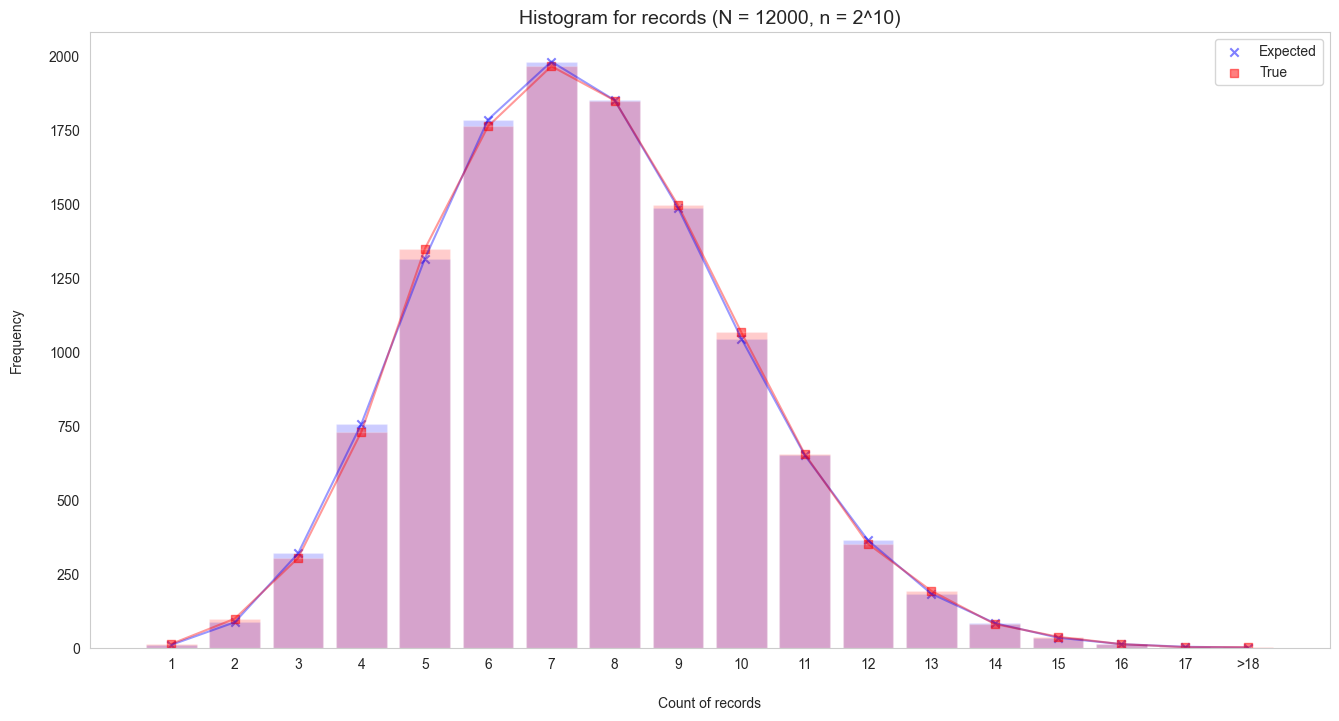

In [1200]:
o_r_3, e_r_3 = get_records(permutations_3)
compare_two_distr_graph(o_r_3, e_r_3, "records")



100%|██████████████████████████████████████| 512/512 [00:00<00:00, 25846.83it/s]


100%|████████████████████████████████| 12000/12000 [00:00<00:00, 1289926.65it/s]


       expected  observed    x
0   7585.446706    7661.0    1
1   1736.991372    1660.0    2
2    759.004969     753.0    3
3    424.383296     469.0    4
4    270.847734     279.0    5
5    187.802886     187.0    6
6    137.851002     118.0    7
7    105.479245      94.0    8
8     83.307535      90.0    9
9     67.459351      66.0   10
10    55.739452      50.0   11
11    46.828903      46.0   12
12    74.293424      76.0   13
13    56.292405      58.0   14
14    44.126098      56.0   15
15    35.518984      42.0   16
16    41.945548      47.0   17
17    41.694085      44.0   18
18    49.703587      41.0   19
19    47.209173      40.0   20
20    41.972763      41.0   21
21    29.971789      41.0   22
22    19.748990      41.0  >23


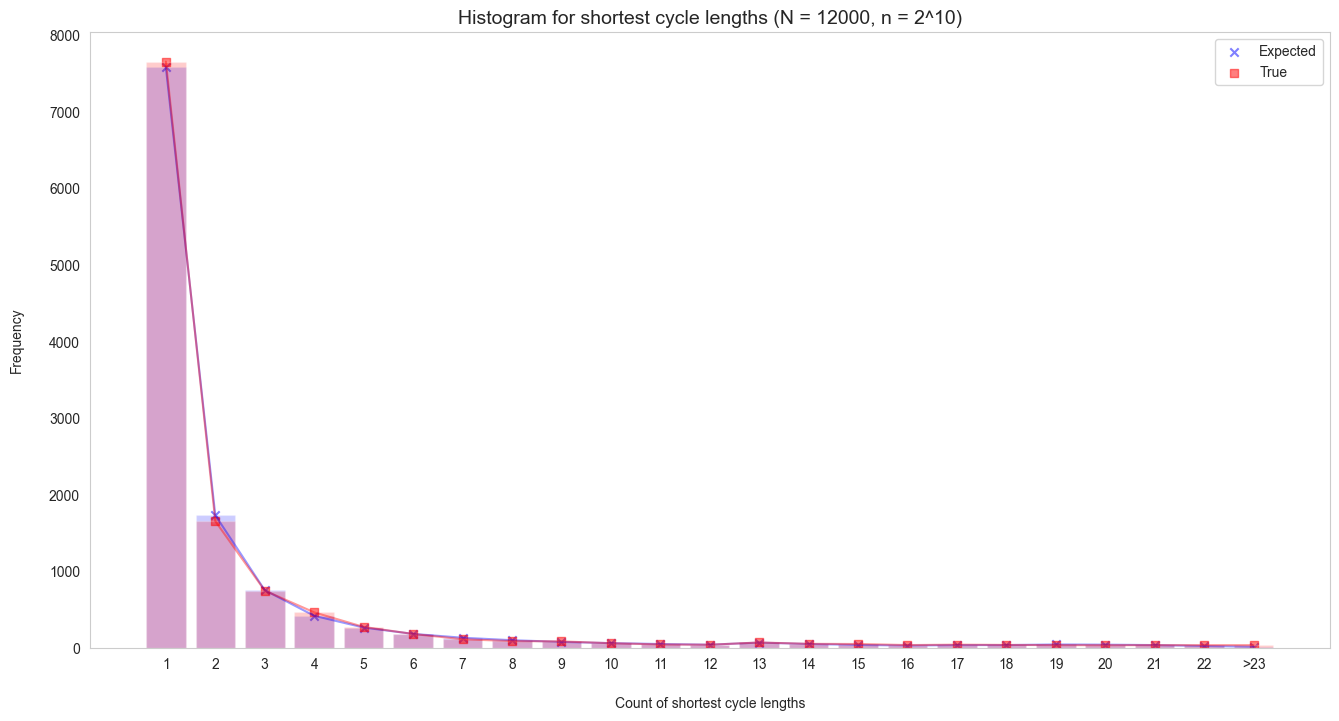

In [1203]:
o_sc_3, e_sc_3 = get_short_cycle_length(permutations_3)
compare_two_distr_graph(o_sc_3, e_sc_3, "shortest cycle lengths")

In [1204]:
o_ord_3, e_ord_3 = get_permutation_orders(permutations_3)
print("ob: ", o_ord_3, "; exp:  ",  e_ord_3)

ob:  21218810320225.184 ; exp:   2542.425639659251


In [1205]:
o_prt_3, e_prt_3 = get_permutation_parity(permutations_3)
print("ob: ", o_prt_3, "; exp:  ",  e_prt_3)

ob:  0.5064166666666666 ; exp:   0.5


In [1206]:
o_inv_3, e_inv_3 = get_permutation_inversions(permutations_3)
print("ob: ", o_inv_3, "; exp:  ",  e_inv_3)

ob:  261860.44075 ; exp:   523776.0


In [1208]:
permutations_4 = []

for iteration in tqdm(range(12000)):
    op = quasigroup_operation_triangle()
    for i in range(1): ## Используем каждую операцию по одному разу
        shift = left_shift(op, random.randint(0, N - 1))
        permutations_4.append(Permutation(gen_permutation(shift)))



  0%|                                                 | 0/12000 [00:00<?, ?it/s]

  0%|                                         | 9/12000 [00:00<02:13, 89.73it/s]

  0%|                                        | 19/12000 [00:00<02:05, 95.60it/s]

  0%|                                        | 30/12000 [00:00<02:02, 98.11it/s]

  0%|▏                                       | 41/12000 [00:00<02:00, 99.43it/s]

  0%|▏                                      | 52/12000 [00:00<01:58, 100.41it/s]

  1%|▏                                      | 63/12000 [00:00<01:58, 100.75it/s]

  1%|▏                                      | 74/12000 [00:00<01:58, 101.06it/s]

  1%|▎                                      | 85/12000 [00:00<01:58, 100.32it/s]

  1%|▎                                       | 96/12000 [00:00<01:59, 99.66it/s]

  1%|▎                                      | 107/12000 [00:01<01:59, 99.91it/s]

  1%|▍                                      | 117/12000 [00:01<01:59, 99.85it/s]

  1%|▍        

  8%|███▏                                   | 964/12000 [00:09<01:52, 97.73it/s]

  8%|███▏                                   | 974/12000 [00:09<01:52, 97.74it/s]

  8%|███▏                                   | 985/12000 [00:09<01:50, 99.31it/s]

  8%|███▏                                  | 996/12000 [00:10<01:49, 100.24it/s]

  8%|███                                  | 1007/12000 [00:10<01:48, 101.08it/s]

  8%|███▏                                 | 1018/12000 [00:10<01:48, 101.33it/s]

  9%|███▏                                 | 1029/12000 [00:10<01:48, 101.17it/s]

  9%|███▏                                 | 1040/12000 [00:10<01:48, 100.84it/s]

  9%|███▏                                 | 1051/12000 [00:10<01:48, 100.46it/s]

  9%|███▎                                 | 1062/12000 [00:10<01:49, 100.21it/s]

  9%|███▎                                 | 1073/12000 [00:10<01:48, 100.68it/s]

  9%|███▎                                 | 1084/12000 [00:10<01:48, 100.63it/s]

  9%|███▍       

 16%|██████                               | 1969/12000 [00:19<01:38, 101.64it/s]

 16%|██████                               | 1980/12000 [00:19<01:38, 101.78it/s]

 17%|██████▏                              | 1991/12000 [00:20<01:38, 101.72it/s]

 17%|██████▏                              | 2002/12000 [00:20<01:38, 101.72it/s]

 17%|██████▏                              | 2013/12000 [00:20<01:38, 101.81it/s]

 17%|██████▏                              | 2024/12000 [00:20<01:38, 101.16it/s]

 17%|██████▎                              | 2035/12000 [00:20<01:38, 101.30it/s]

 17%|██████▎                              | 2046/12000 [00:20<01:38, 101.20it/s]

 17%|██████▎                              | 2057/12000 [00:20<01:38, 101.09it/s]

 17%|██████▍                              | 2068/12000 [00:20<01:37, 101.38it/s]

 17%|██████▍                              | 2079/12000 [00:20<01:38, 101.23it/s]

 17%|██████▍                              | 2090/12000 [00:21<01:37, 101.20it/s]

 18%|██████▍    

 25%|█████████▍                            | 2987/12000 [00:29<01:31, 98.77it/s]

 25%|█████████▍                            | 2998/12000 [00:30<01:30, 99.40it/s]

 25%|█████████▎                           | 3009/12000 [00:30<01:29, 100.56it/s]

 25%|█████████▎                           | 3020/12000 [00:30<01:28, 101.43it/s]

 25%|█████████▎                           | 3031/12000 [00:30<01:28, 101.71it/s]

 25%|█████████▍                           | 3042/12000 [00:30<01:27, 102.14it/s]

 25%|█████████▍                           | 3053/12000 [00:30<01:27, 102.00it/s]

 26%|█████████▍                           | 3064/12000 [00:30<01:27, 102.05it/s]

 26%|█████████▍                           | 3075/12000 [00:30<01:27, 102.24it/s]

 26%|█████████▌                           | 3086/12000 [00:30<01:27, 102.42it/s]

 26%|█████████▌                           | 3097/12000 [00:30<01:26, 102.62it/s]

 26%|█████████▌                           | 3108/12000 [00:31<01:26, 102.43it/s]

 26%|█████████▌ 

 33%|████████████▎                        | 4009/12000 [00:39<01:18, 101.62it/s]

 34%|████████████▍                        | 4020/12000 [00:40<01:18, 101.44it/s]

 34%|████████████▍                        | 4031/12000 [00:40<01:18, 101.62it/s]

 34%|████████████▍                        | 4042/12000 [00:40<01:18, 101.72it/s]

 34%|████████████▍                        | 4053/12000 [00:40<01:19, 100.34it/s]

 34%|████████████▌                        | 4064/12000 [00:40<01:18, 100.65it/s]

 34%|████████████▌                        | 4075/12000 [00:40<01:18, 100.84it/s]

 34%|████████████▌                        | 4086/12000 [00:40<01:18, 101.13it/s]

 34%|████████████▋                        | 4097/12000 [00:40<01:17, 101.52it/s]

 34%|████████████▋                        | 4108/12000 [00:40<01:17, 101.91it/s]

 34%|████████████▋                        | 4119/12000 [00:41<01:16, 102.40it/s]

 34%|████████████▋                        | 4130/12000 [00:41<01:16, 102.47it/s]

 35%|███████████

 42%|███████████████▌                     | 5032/12000 [00:49<01:08, 101.66it/s]

 42%|███████████████▌                     | 5043/12000 [00:50<01:08, 101.38it/s]

 42%|███████████████▌                     | 5054/12000 [00:50<01:08, 101.67it/s]

 42%|███████████████▌                     | 5065/12000 [00:50<01:08, 101.73it/s]

 42%|███████████████▋                     | 5076/12000 [00:50<01:08, 101.69it/s]

 42%|███████████████▋                     | 5087/12000 [00:50<01:07, 101.95it/s]

 42%|███████████████▋                     | 5098/12000 [00:50<01:08, 101.07it/s]

 43%|███████████████▊                     | 5109/12000 [00:50<01:07, 101.50it/s]

 43%|███████████████▊                     | 5120/12000 [00:50<01:07, 101.49it/s]

 43%|███████████████▊                     | 5131/12000 [00:50<01:07, 101.75it/s]

 43%|███████████████▊                     | 5142/12000 [00:51<01:07, 102.01it/s]

 43%|███████████████▉                     | 5153/12000 [00:51<01:06, 102.24it/s]

 43%|███████████

 50%|██████████████████▋                  | 6055/12000 [01:00<00:58, 101.77it/s]

 51%|██████████████████▋                  | 6066/12000 [01:00<00:58, 101.93it/s]

 51%|██████████████████▋                  | 6077/12000 [01:00<00:58, 101.97it/s]

 51%|██████████████████▊                  | 6088/12000 [01:00<00:58, 101.60it/s]

 51%|██████████████████▊                  | 6099/12000 [01:00<00:57, 101.77it/s]

 51%|██████████████████▊                  | 6110/12000 [01:00<00:57, 102.06it/s]

 51%|██████████████████▊                  | 6121/12000 [01:00<00:57, 102.32it/s]

 51%|██████████████████▉                  | 6132/12000 [01:00<00:57, 102.05it/s]

 51%|██████████████████▉                  | 6143/12000 [01:00<00:57, 101.74it/s]

 51%|██████████████████▉                  | 6154/12000 [01:01<00:57, 102.10it/s]

 51%|███████████████████                  | 6165/12000 [01:01<00:57, 102.11it/s]

 51%|███████████████████                  | 6176/12000 [01:01<00:57, 101.70it/s]

 52%|███████████

 59%|█████████████████████▊               | 7076/12000 [01:10<00:48, 101.56it/s]

 59%|█████████████████████▊               | 7087/12000 [01:10<00:48, 101.47it/s]

 59%|█████████████████████▉               | 7098/12000 [01:10<00:48, 101.60it/s]

 59%|█████████████████████▉               | 7109/12000 [01:10<00:48, 101.85it/s]

 59%|█████████████████████▉               | 7120/12000 [01:10<00:47, 101.97it/s]

 59%|█████████████████████▉               | 7131/12000 [01:10<00:47, 102.09it/s]

 60%|██████████████████████               | 7142/12000 [01:10<00:47, 102.22it/s]

 60%|██████████████████████               | 7153/12000 [01:10<00:47, 101.88it/s]

 60%|██████████████████████               | 7164/12000 [01:11<00:47, 101.92it/s]

 60%|██████████████████████               | 7175/12000 [01:11<00:47, 102.14it/s]

 60%|██████████████████████▏              | 7186/12000 [01:11<00:47, 102.00it/s]

 60%|██████████████████████▏              | 7197/12000 [01:11<00:46, 102.20it/s]

 60%|███████████

 67%|█████████████████████████▌            | 8063/12000 [01:20<00:40, 97.91it/s]

 67%|█████████████████████████▌            | 8073/12000 [01:20<00:40, 97.20it/s]

 67%|█████████████████████████▌            | 8083/12000 [01:20<00:40, 95.75it/s]

 67%|█████████████████████████▋            | 8093/12000 [01:20<00:40, 95.42it/s]

 68%|█████████████████████████▋            | 8103/12000 [01:20<00:40, 95.43it/s]

 68%|█████████████████████████▋            | 8113/12000 [01:20<00:40, 95.45it/s]

 68%|█████████████████████████▋            | 8123/12000 [01:20<00:40, 95.80it/s]

 68%|█████████████████████████▊            | 8133/12000 [01:20<00:40, 95.38it/s]

 68%|█████████████████████████▊            | 8143/12000 [01:20<00:40, 95.33it/s]

 68%|█████████████████████████▊            | 8153/12000 [01:21<00:40, 95.41it/s]

 68%|█████████████████████████▊            | 8163/12000 [01:21<00:40, 95.36it/s]

 68%|█████████████████████████▉            | 8173/12000 [01:21<00:40, 95.26it/s]

 68%|███████████

 75%|████████████████████████████▌         | 9037/12000 [01:29<00:29, 99.79it/s]

 75%|████████████████████████████▋         | 9047/12000 [01:30<00:29, 99.67it/s]

 75%|████████████████████████████▋         | 9057/12000 [01:30<00:29, 99.38it/s]

 76%|████████████████████████████▋         | 9068/12000 [01:30<00:29, 99.90it/s]

 76%|████████████████████████████▋         | 9078/12000 [01:30<00:29, 99.27it/s]

 76%|████████████████████████████▊         | 9088/12000 [01:30<00:29, 99.37it/s]

 76%|████████████████████████████▊         | 9099/12000 [01:30<00:29, 99.89it/s]

 76%|████████████████████████████         | 9110/12000 [01:30<00:28, 100.22it/s]

 76%|████████████████████████████         | 9121/12000 [01:30<00:28, 100.04it/s]

 76%|████████████████████████████▏        | 9132/12000 [01:30<00:28, 100.32it/s]

 76%|████████████████████████████▉         | 9143/12000 [01:31<00:28, 99.95it/s]

 76%|████████████████████████████▏        | 9154/12000 [01:31<00:28, 100.19it/s]

 76%|███████████

 84%|██████████████████████████████▏     | 10056/12000 [01:40<00:19, 101.60it/s]

 84%|██████████████████████████████▏     | 10067/12000 [01:40<00:19, 101.51it/s]

 84%|██████████████████████████████▏     | 10078/12000 [01:40<00:18, 101.31it/s]

 84%|██████████████████████████████▎     | 10089/12000 [01:40<00:18, 101.11it/s]

 84%|██████████████████████████████▎     | 10100/12000 [01:40<00:18, 101.04it/s]

 84%|██████████████████████████████▎     | 10111/12000 [01:40<00:18, 101.03it/s]

 84%|██████████████████████████████▎     | 10122/12000 [01:40<00:18, 101.12it/s]

 84%|██████████████████████████████▍     | 10133/12000 [01:40<00:18, 101.11it/s]

 85%|██████████████████████████████▍     | 10144/12000 [01:40<00:18, 101.59it/s]

 85%|██████████████████████████████▍     | 10155/12000 [01:41<00:18, 101.52it/s]

 85%|██████████████████████████████▍     | 10166/12000 [01:41<00:17, 101.96it/s]

 85%|██████████████████████████████▌     | 10177/12000 [01:41<00:17, 101.71it/s]

 85%|███████████

 92%|██████████████████████████████████▏  | 11078/12000 [01:50<00:09, 99.84it/s]

 92%|██████████████████████████████████▏  | 11088/12000 [01:50<00:09, 99.22it/s]

 92%|██████████████████████████████████▏  | 11099/12000 [01:50<00:09, 99.56it/s]

 93%|██████████████████████████████████▎  | 11110/12000 [01:50<00:08, 99.94it/s]

 93%|██████████████████████████████████▎  | 11120/12000 [01:50<00:08, 99.73it/s]

 93%|██████████████████████████████████▎  | 11130/12000 [01:50<00:08, 99.17it/s]

 93%|██████████████████████████████████▎  | 11140/12000 [01:50<00:08, 99.12it/s]

 93%|██████████████████████████████████▍  | 11150/12000 [01:50<00:08, 99.03it/s]

 93%|██████████████████████████████████▍  | 11161/12000 [01:50<00:08, 99.46it/s]

 93%|██████████████████████████████████▍  | 11171/12000 [01:51<00:08, 99.47it/s]

 93%|██████████████████████████████████▍  | 11181/12000 [01:51<00:08, 99.23it/s]

 93%|██████████████████████████████████▌  | 11191/12000 [01:51<00:08, 99.33it/s]

 93%|███████████



  0%|                                                  | 0/1025 [00:00<?, ?it/s]

 12%|████▌                                 | 122/1025 [00:00<00:00, 1211.22it/s]

 29%|██████████▉                           | 294/1025 [00:00<00:00, 1508.35it/s]

100%|█████████████████████████████████████| 1025/1025 [00:00<00:00, 2716.42it/s]


  0%|                                                 | 0/12000 [00:00<?, ?it/s]

  0%|                                         | 8/12000 [00:00<02:32, 78.71it/s]

  0%|                                        | 16/12000 [00:00<02:45, 72.26it/s]

  0%|                                        | 25/12000 [00:00<02:34, 77.55it/s]

  0%|                                        | 33/12000 [00:00<02:36, 76.50it/s]

  0%|▏                                       | 41/12000 [00:00<02:40, 74.57it/s]

  0%|▏                                       | 49/12000 [00:00<02:39, 74.82it/s]

  0%|▏                                       | 57/12000 [00:00<02:45, 72.35it/s]

  1%|▏       

  6%|██▎                                    | 717/12000 [00:12<12:54, 14.56it/s]

  6%|██▎                                    | 726/12000 [00:12<09:30, 19.74it/s]

  6%|██▍                                    | 734/12000 [00:12<07:27, 25.18it/s]

  6%|██▍                                    | 742/12000 [00:12<06:01, 31.19it/s]

  6%|██▍                                    | 750/12000 [00:13<04:57, 37.76it/s]

  6%|██▍                                    | 759/12000 [00:13<04:06, 45.64it/s]

  6%|██▍                                    | 767/12000 [00:13<03:35, 52.08it/s]

  6%|██▌                                    | 775/12000 [00:13<03:16, 57.01it/s]

  7%|██▌                                    | 783/12000 [00:13<03:02, 61.43it/s]

  7%|██▌                                    | 791/12000 [00:13<02:51, 65.52it/s]

  7%|██▌                                    | 799/12000 [00:13<02:42, 69.07it/s]

  7%|██▌                                    | 807/12000 [00:13<02:37, 71.14it/s]

  7%|██▋        

 12%|████▋                                 | 1484/12000 [00:22<02:19, 75.56it/s]

 12%|████▋                                 | 1492/12000 [00:22<02:18, 75.87it/s]

 12%|████▊                                 | 1500/12000 [00:22<02:18, 75.88it/s]

 13%|████▊                                 | 1508/12000 [00:22<02:18, 75.57it/s]

 13%|████▊                                 | 1517/12000 [00:23<02:14, 77.70it/s]

 13%|████▊                                 | 1526/12000 [00:23<02:11, 79.38it/s]

 13%|████▊                                 | 1535/12000 [00:23<02:10, 80.44it/s]

 13%|████▉                                 | 1544/12000 [00:23<02:08, 81.22it/s]

 13%|████▉                                 | 1553/12000 [00:23<02:11, 79.49it/s]

 13%|████▉                                 | 1561/12000 [00:23<02:14, 77.36it/s]

 13%|████▉                                 | 1570/12000 [00:23<02:13, 78.17it/s]

 13%|████▉                                 | 1578/12000 [00:23<02:13, 78.10it/s]

 13%|█████      

 19%|███████▏                              | 2257/12000 [00:32<02:05, 77.90it/s]

 19%|███████▏                              | 2265/12000 [00:32<02:06, 77.19it/s]

 19%|███████▏                              | 2273/12000 [00:32<02:07, 76.48it/s]

 19%|███████▏                              | 2281/12000 [00:32<02:07, 76.16it/s]

 19%|███████▏                              | 2289/12000 [00:33<02:06, 76.81it/s]

 19%|███████▎                              | 2298/12000 [00:33<02:03, 78.60it/s]

 19%|███████▎                              | 2306/12000 [00:33<02:06, 76.50it/s]

 19%|███████▎                              | 2314/12000 [00:33<02:09, 74.73it/s]

 19%|███████▎                              | 2322/12000 [00:33<02:09, 74.56it/s]

 19%|███████▍                              | 2330/12000 [00:33<02:11, 73.56it/s]

 19%|███████▍                              | 2338/12000 [00:33<02:13, 72.28it/s]

 20%|███████▍                              | 2346/12000 [00:33<02:10, 74.03it/s]

 20%|███████▍   

 25%|█████████▌                            | 3014/12000 [00:42<02:01, 73.85it/s]

 25%|█████████▌                            | 3022/12000 [00:42<02:04, 72.27it/s]

 25%|█████████▌                            | 3030/12000 [00:42<02:03, 72.35it/s]

 25%|█████████▌                            | 3039/12000 [00:43<01:58, 75.78it/s]

 25%|█████████▋                            | 3048/12000 [00:43<01:56, 76.82it/s]

 25%|█████████▋                            | 3056/12000 [00:43<01:57, 76.12it/s]

 26%|█████████▋                            | 3064/12000 [00:43<01:57, 75.99it/s]

 26%|█████████▋                            | 3073/12000 [00:43<01:54, 78.27it/s]

 26%|█████████▊                            | 3081/12000 [00:43<01:56, 76.56it/s]

 26%|█████████▊                            | 3089/12000 [00:43<01:57, 76.10it/s]

 26%|█████████▊                            | 3097/12000 [00:43<01:56, 76.68it/s]

 26%|█████████▊                            | 3105/12000 [00:43<01:55, 76.87it/s]

 26%|█████████▊ 

 31%|███████████▉                          | 3775/12000 [00:52<01:52, 73.32it/s]

 32%|███████████▉                          | 3783/12000 [00:52<01:54, 71.63it/s]

 32%|████████████                          | 3791/12000 [00:53<01:53, 72.30it/s]

 32%|████████████                          | 3799/12000 [00:53<01:51, 73.39it/s]

 32%|████████████                          | 3807/12000 [00:53<01:50, 74.36it/s]

 32%|████████████                          | 3815/12000 [00:53<01:50, 74.07it/s]

 32%|████████████                          | 3823/12000 [00:53<01:50, 73.87it/s]

 32%|████████████▏                         | 3831/12000 [00:53<01:52, 72.51it/s]

 32%|████████████▏                         | 3839/12000 [00:53<01:54, 71.26it/s]

 32%|████████████▏                         | 3848/12000 [00:53<01:50, 73.48it/s]

 32%|████████████▏                         | 3857/12000 [00:53<01:47, 75.68it/s]

 32%|████████████▏                         | 3865/12000 [00:54<01:46, 76.62it/s]

 32%|███████████

 38%|██████████████▎                       | 4537/12000 [01:03<01:39, 75.10it/s]

 38%|██████████████▍                       | 4545/12000 [01:03<01:38, 75.59it/s]

 38%|██████████████▍                       | 4553/12000 [01:03<01:42, 72.71it/s]

 38%|██████████████▍                       | 4561/12000 [01:03<01:45, 70.65it/s]

 38%|██████████████▍                       | 4569/12000 [01:03<01:46, 70.02it/s]

 38%|██████████████▍                       | 4577/12000 [01:03<01:45, 70.41it/s]

 38%|██████████████▌                       | 4585/12000 [01:03<01:42, 72.65it/s]

 38%|██████████████▌                       | 4593/12000 [01:03<01:39, 74.48it/s]

 38%|██████████████▌                       | 4601/12000 [01:03<01:38, 74.99it/s]

 38%|██████████████▌                       | 4609/12000 [01:04<01:38, 75.36it/s]

 38%|██████████████▌                       | 4618/12000 [01:04<01:35, 77.12it/s]

 39%|██████████████▋                       | 4627/12000 [01:04<01:34, 78.39it/s]

 39%|███████████

 44%|████████████████▊                     | 5292/12000 [01:13<01:32, 72.25it/s]

 44%|████████████████▊                     | 5300/12000 [01:13<01:34, 70.94it/s]

 44%|████████████████▊                     | 5308/12000 [01:13<01:31, 73.00it/s]

 44%|████████████████▊                     | 5316/12000 [01:13<01:29, 74.69it/s]

 44%|████████████████▊                     | 5324/12000 [01:13<01:29, 74.41it/s]

 44%|████████████████▉                     | 5333/12000 [01:13<01:26, 77.38it/s]

 45%|████████████████▉                     | 5342/12000 [01:13<01:23, 79.32it/s]

 45%|████████████████▉                     | 5351/12000 [01:14<01:23, 79.84it/s]

 45%|████████████████▉                     | 5359/12000 [01:14<01:24, 78.61it/s]

 45%|████████████████▉                     | 5367/12000 [01:14<01:26, 76.74it/s]

 45%|█████████████████                     | 5375/12000 [01:14<01:29, 74.26it/s]

 45%|█████████████████                     | 5384/12000 [01:14<01:25, 77.03it/s]

 45%|███████████

 50%|███████████████████▏                  | 6048/12000 [01:27<01:16, 77.37it/s]

 50%|███████████████████▏                  | 6056/12000 [01:27<01:16, 77.49it/s]

 51%|███████████████████▏                  | 6064/12000 [01:27<01:15, 78.18it/s]

 51%|███████████████████▏                  | 6072/12000 [01:27<01:16, 77.85it/s]

 51%|███████████████████▎                  | 6080/12000 [01:27<01:17, 76.43it/s]

 51%|███████████████████▎                  | 6089/12000 [01:27<01:15, 78.53it/s]

 51%|███████████████████▎                  | 6098/12000 [01:28<01:14, 79.17it/s]

 51%|███████████████████▎                  | 6106/12000 [01:28<01:14, 78.71it/s]

 51%|███████████████████▎                  | 6114/12000 [01:28<01:17, 75.97it/s]

 51%|███████████████████▍                  | 6122/12000 [01:28<01:16, 76.60it/s]

 51%|███████████████████▍                  | 6131/12000 [01:28<01:15, 77.55it/s]

 51%|███████████████████▍                  | 6139/12000 [01:28<01:18, 74.99it/s]

 51%|███████████

 57%|█████████████████████▌                | 6817/12000 [01:37<01:03, 81.29it/s]

 57%|█████████████████████▌                | 6826/12000 [01:37<01:04, 80.35it/s]

 57%|█████████████████████▋                | 6835/12000 [01:37<01:07, 77.01it/s]

 57%|█████████████████████▋                | 6844/12000 [01:37<01:05, 78.24it/s]

 57%|█████████████████████▋                | 6853/12000 [01:37<01:04, 79.94it/s]

 57%|█████████████████████▋                | 6862/12000 [01:37<01:05, 78.79it/s]

 57%|█████████████████████▊                | 6870/12000 [01:38<01:05, 77.75it/s]

 57%|█████████████████████▊                | 6879/12000 [01:38<01:04, 78.93it/s]

 57%|█████████████████████▊                | 6887/12000 [01:38<01:07, 75.38it/s]

 57%|█████████████████████▊                | 6895/12000 [01:38<01:06, 76.35it/s]

 58%|█████████████████████▊                | 6903/12000 [01:38<01:07, 75.77it/s]

 58%|█████████████████████▉                | 6912/12000 [01:38<01:05, 77.65it/s]

 58%|███████████

 63%|████████████████████████              | 7606/12000 [01:47<00:55, 79.16it/s]

 63%|████████████████████████              | 7614/12000 [01:47<00:58, 75.56it/s]

 64%|████████████████████████▏             | 7622/12000 [01:47<00:58, 75.44it/s]

 64%|████████████████████████▏             | 7631/12000 [01:47<00:56, 77.08it/s]

 64%|████████████████████████▏             | 7640/12000 [01:47<00:55, 78.19it/s]

 64%|████████████████████████▏             | 7648/12000 [01:48<00:55, 78.46it/s]

 64%|████████████████████████▏             | 7656/12000 [01:48<00:56, 76.73it/s]

 64%|████████████████████████▎             | 7665/12000 [01:48<00:55, 77.65it/s]

 64%|████████████████████████▎             | 7673/12000 [01:48<00:56, 76.25it/s]

 64%|████████████████████████▎             | 7682/12000 [01:48<00:55, 78.19it/s]

 64%|████████████████████████▎             | 7690/12000 [01:48<00:55, 77.10it/s]

 64%|████████████████████████▍             | 7700/12000 [01:48<00:53, 80.60it/s]

 64%|███████████

 70%|██████████████████████████▌           | 8394/12000 [01:57<00:46, 77.45it/s]

 70%|██████████████████████████▌           | 8403/12000 [01:57<00:45, 78.74it/s]

 70%|██████████████████████████▋           | 8411/12000 [01:57<00:45, 79.03it/s]

 70%|██████████████████████████▋           | 8420/12000 [01:57<00:44, 79.56it/s]

 70%|██████████████████████████▋           | 8428/12000 [01:58<00:45, 78.92it/s]

 70%|██████████████████████████▋           | 8436/12000 [01:58<00:45, 78.89it/s]

 70%|██████████████████████████▋           | 8444/12000 [01:58<00:45, 77.33it/s]

 70%|██████████████████████████▊           | 8452/12000 [01:58<00:46, 76.88it/s]

 70%|██████████████████████████▊           | 8460/12000 [01:58<00:46, 76.08it/s]

 71%|██████████████████████████▊           | 8468/12000 [01:58<00:47, 73.85it/s]

 71%|██████████████████████████▊           | 8476/12000 [01:58<00:47, 74.49it/s]

 71%|██████████████████████████▊           | 8484/12000 [01:58<00:47, 74.52it/s]

 71%|███████████

 76%|█████████████████████████████         | 9170/12000 [02:07<00:35, 78.84it/s]

 76%|█████████████████████████████         | 9178/12000 [02:07<00:35, 78.97it/s]

 77%|█████████████████████████████         | 9186/12000 [02:07<00:36, 76.56it/s]

 77%|█████████████████████████████         | 9194/12000 [02:08<00:36, 76.11it/s]

 77%|█████████████████████████████▏        | 9202/12000 [02:08<00:36, 76.56it/s]

 77%|█████████████████████████████▏        | 9210/12000 [02:08<00:36, 75.95it/s]

 77%|█████████████████████████████▏        | 9218/12000 [02:08<00:37, 74.52it/s]

 77%|█████████████████████████████▏        | 9226/12000 [02:08<00:36, 75.52it/s]

 77%|█████████████████████████████▏        | 9234/12000 [02:08<00:37, 73.23it/s]

 77%|█████████████████████████████▎        | 9242/12000 [02:08<00:37, 73.98it/s]

 77%|█████████████████████████████▎        | 9251/12000 [02:08<00:35, 76.44it/s]

 77%|█████████████████████████████▎        | 9259/12000 [02:08<00:36, 74.37it/s]

 77%|███████████

 83%|███████████████████████████████▍      | 9945/12000 [02:17<00:25, 82.08it/s]

 83%|███████████████████████████████▌      | 9954/12000 [02:17<00:25, 80.65it/s]

 83%|███████████████████████████████▌      | 9963/12000 [02:18<00:25, 79.95it/s]

 83%|███████████████████████████████▌      | 9972/12000 [02:18<00:25, 80.82it/s]

 83%|███████████████████████████████▌      | 9981/12000 [02:18<00:25, 79.96it/s]

 83%|███████████████████████████████▋      | 9990/12000 [02:18<00:24, 80.76it/s]

 83%|███████████████████████████████▋      | 9999/12000 [02:18<00:26, 76.94it/s]

 83%|██████████████████████████████▊      | 10007/12000 [02:18<00:25, 77.36it/s]

 83%|██████████████████████████████▉      | 10016/12000 [02:18<00:25, 78.32it/s]

 84%|██████████████████████████████▉      | 10025/12000 [02:18<00:24, 80.16it/s]

 84%|██████████████████████████████▉      | 10034/12000 [02:18<00:24, 80.98it/s]

 84%|██████████████████████████████▉      | 10043/12000 [02:19<00:24, 79.75it/s]

 84%|███████████

 89%|█████████████████████████████████    | 10729/12000 [02:27<00:16, 78.18it/s]

 89%|█████████████████████████████████    | 10738/12000 [02:27<00:15, 79.40it/s]

 90%|█████████████████████████████████▏   | 10747/12000 [02:28<00:15, 80.30it/s]

 90%|█████████████████████████████████▏   | 10756/12000 [02:28<00:15, 77.98it/s]

 90%|█████████████████████████████████▏   | 10765/12000 [02:28<00:15, 80.08it/s]

 90%|█████████████████████████████████▏   | 10774/12000 [02:28<00:15, 80.25it/s]

 90%|█████████████████████████████████▏   | 10783/12000 [02:28<00:15, 78.78it/s]

 90%|█████████████████████████████████▎   | 10792/12000 [02:28<00:14, 80.71it/s]

 90%|█████████████████████████████████▎   | 10801/12000 [02:28<00:15, 78.47it/s]

 90%|█████████████████████████████████▎   | 10809/12000 [02:28<00:15, 78.26it/s]

 90%|█████████████████████████████████▎   | 10818/12000 [02:28<00:14, 79.94it/s]

 90%|█████████████████████████████████▍   | 10827/12000 [02:29<00:14, 79.13it/s]

 90%|███████████

 96%|███████████████████████████████████▍ | 11505/12000 [02:37<00:06, 77.01it/s]

 96%|███████████████████████████████████▍ | 11513/12000 [02:38<00:06, 75.97it/s]

 96%|███████████████████████████████████▌ | 11522/12000 [02:38<00:06, 77.04it/s]

 96%|███████████████████████████████████▌ | 11530/12000 [02:38<00:06, 76.79it/s]

 96%|███████████████████████████████████▌ | 11538/12000 [02:38<00:06, 74.96it/s]

 96%|███████████████████████████████████▌ | 11546/12000 [02:38<00:06, 75.25it/s]

 96%|███████████████████████████████████▌ | 11554/12000 [02:38<00:06, 74.08it/s]

 96%|███████████████████████████████████▋ | 11562/12000 [02:38<00:05, 74.59it/s]

 96%|███████████████████████████████████▋ | 11570/12000 [02:38<00:05, 74.68it/s]

 96%|███████████████████████████████████▋ | 11579/12000 [02:38<00:05, 77.10it/s]

 97%|███████████████████████████████████▋ | 11587/12000 [02:39<00:05, 77.91it/s]

 97%|███████████████████████████████████▊ | 11595/12000 [02:39<00:05, 75.57it/s]

 97%|███████████

         expected  observed    x
0    4.414553e+03   11938.0    1
1    8.829107e+03   11938.0    2
2    2.943036e+03       1.0    3
3    2.207277e+02       1.0    4
4    7.007227e+00       1.0    5
5    1.229904e-01       3.0    6
6    2.241316e-10       4.0    7
7    7.411072e-21       1.0    8
8    1.730081e-32       7.0    9
9    3.630187e-58       2.0   10
10   3.533472e-86       6.0   11
11  6.245299e-116       1.0   12
12  4.497966e-147       1.0   13
13  1.153735e-212      11.0   14
14   0.000000e+00       3.0   15
15   0.000000e+00       7.0   16
16   0.000000e+00       1.0   17
17   0.000000e+00       1.0   18
18   0.000000e+00       3.0   19
19   0.000000e+00       1.0   20
20   0.000000e+00       4.0   21
21   0.000000e+00       1.0   22
22   0.000000e+00       1.0   23
23   0.000000e+00       1.0  >24


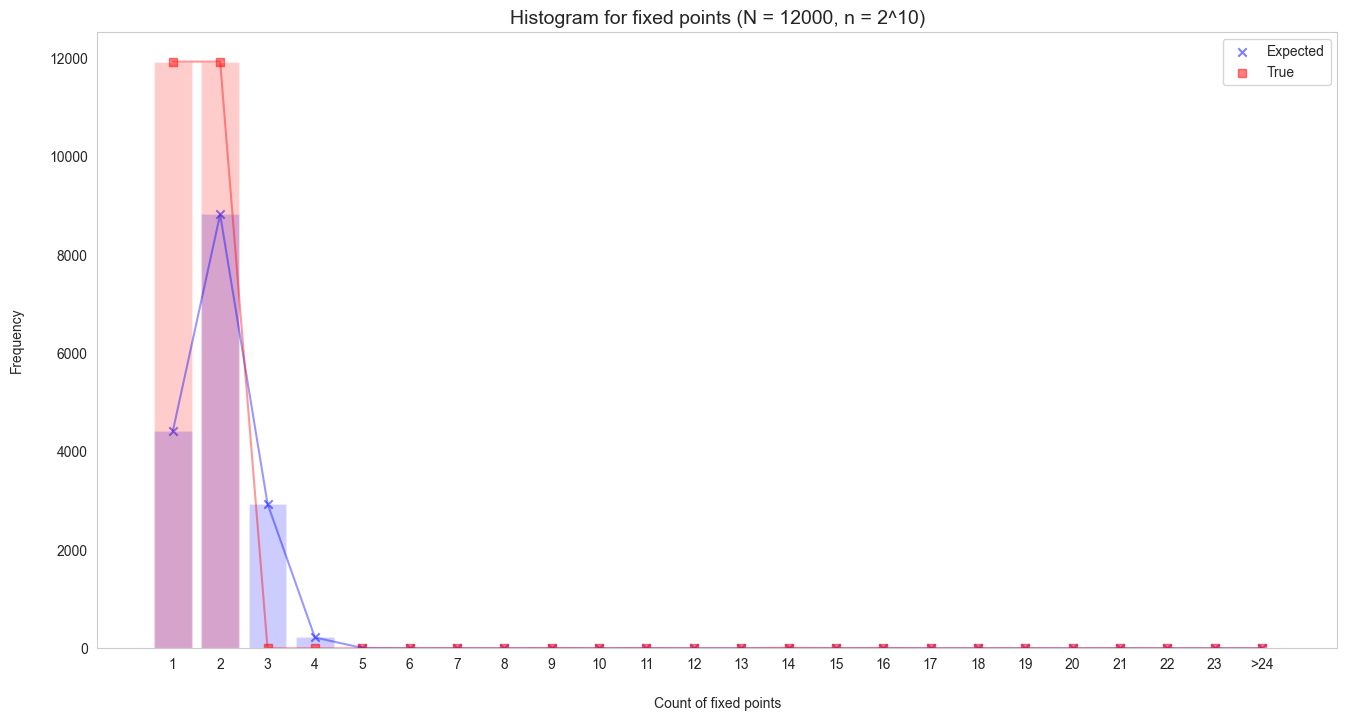

In [1210]:
o_fp_4, e_fp_4 = get_fixed_points(permutations_4)
compare_two_distr_graph(o_fp_4, e_fp_4, "fixed points")

100%|███████████████████████████████████| 12000/12000 [00:04<00:00, 2829.97it/s]


         expected  observed    x
0    1.199249e+04     120.0    1
1    7.510899e+00     209.0    2
2    2.083152e-10     167.0    3
3    2.866406e-25     375.0    4
4    4.568981e-43     164.0    5
5    4.080037e-63     250.0    6
6    5.267814e-85     161.0    7
7   1.853670e-108     746.0    8
8   2.798762e-133     166.0    9
9   2.549352e-159     269.0   10
10  1.826142e-186     183.0   11
11  1.271312e-214     106.0   12
12  4.959071e-240     449.0   13
13  1.022437e-243     100.0   14
14  4.087105e-266     108.0   15
15  1.096429e-273     340.0   16
16  1.768894e-304      98.0   17
17  4.940656e-324     167.0   18
18   0.000000e+00     110.0   19
19   0.000000e+00    1380.0   20
20   0.000000e+00     166.0   21
21   0.000000e+00     319.0   22
22   0.000000e+00      95.0   23
23   0.000000e+00      96.0   24
24   0.000000e+00     185.0   25
25   0.000000e+00     544.0   26
26   0.000000e+00     175.0   27
27   0.000000e+00     328.0   28
28   0.000000e+00     168.0   29
29   0.000

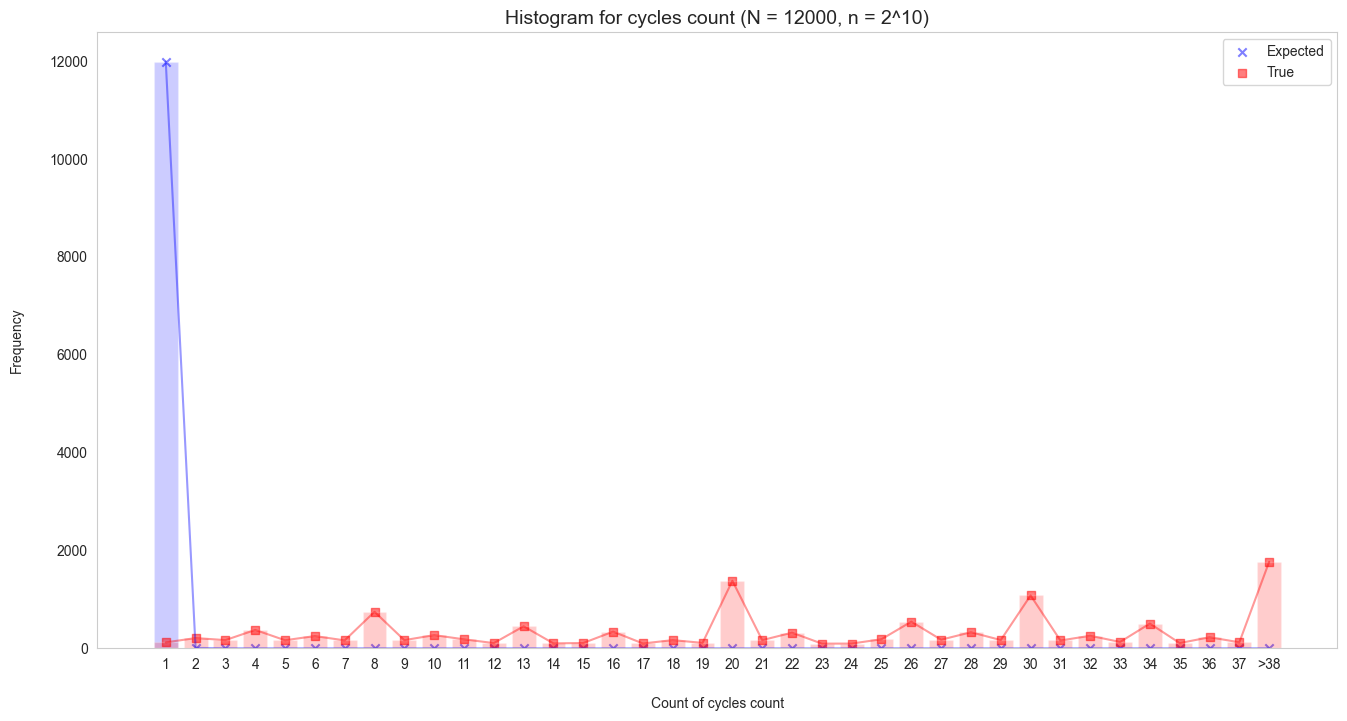

In [1215]:
o_сс_4, e_сc_4 = get_cycles_count(permutations_4)
compare_two_distr_graph(o_сс_4, e_сc_4, "cycles count")

100%|███████████████████████████████████████| 1024/1024 [02:40<00:00,  6.38it/s]


         expected  observed    x
0    9.970546e+01     119.0    1
1    1.079731e+03     409.0    2
2    3.103702e+03     159.0    3
3    3.836397e+03     775.0    4
4    2.536087e+03     146.0    5
5    1.017616e+03     387.0    6
6    2.693575e+02     117.0    7
7    4.989322e+01    1286.0    8
8    6.758974e+00     103.0    9
9    6.929702e-01     300.0   10
10   5.526105e-02     101.0   11
11   3.505106e-03     610.0   12
12   1.877758e-04     295.0   13
13   2.759626e-07      96.0   14
14   1.126170e-09    1299.0   15
15   2.082292e-10     229.0   16
16   8.594646e-14     409.0   17
17   2.068913e-17     163.0   18
18   3.049715e-21     655.0   19
19   2.866228e-25     104.0   20
20   1.776828e-29     256.0   21
21   7.478933e-34     105.0   22
22   9.614679e-33     250.0   23
23   3.077693e-37     112.0   24
24   6.516429e-42     890.0   25
25   4.568981e-43      96.0   26
26   1.370639e-51     194.0   27
27   8.337908e-62     293.0   28
28   1.746163e-72     136.0   29
29   1.373

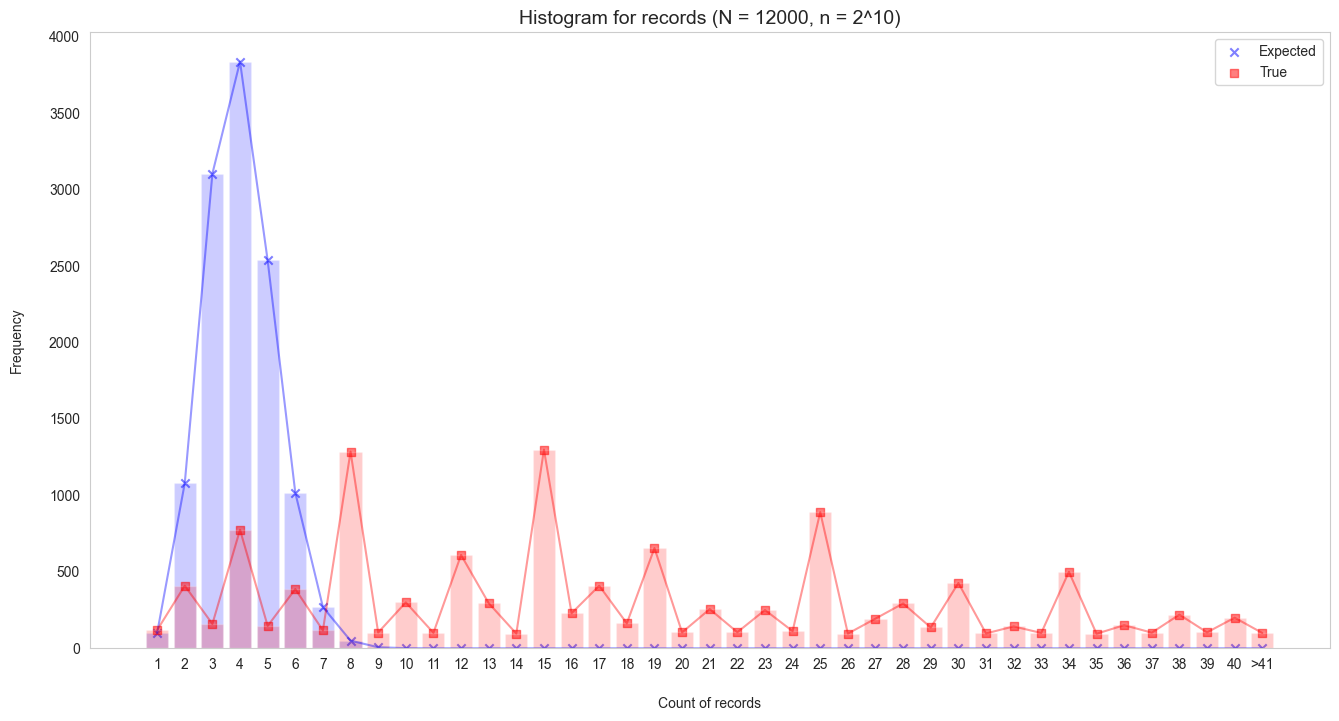

In [1216]:
o_r_4, e_r_4 = get_records(permutations_4)
compare_two_distr_graph(o_r_4, e_r_4, "records")

100%|█████████████████████████████████| 12000/12000 [00:00<00:00, 182784.23it/s]


      expected  observed   x
0  9322.438078    7572.0   1
1   759.004969    2609.0   2
2   424.383296    1068.0   3
3   270.847734     459.0   4
4   187.802886     186.0   5
5   449.836585     106.0  >6


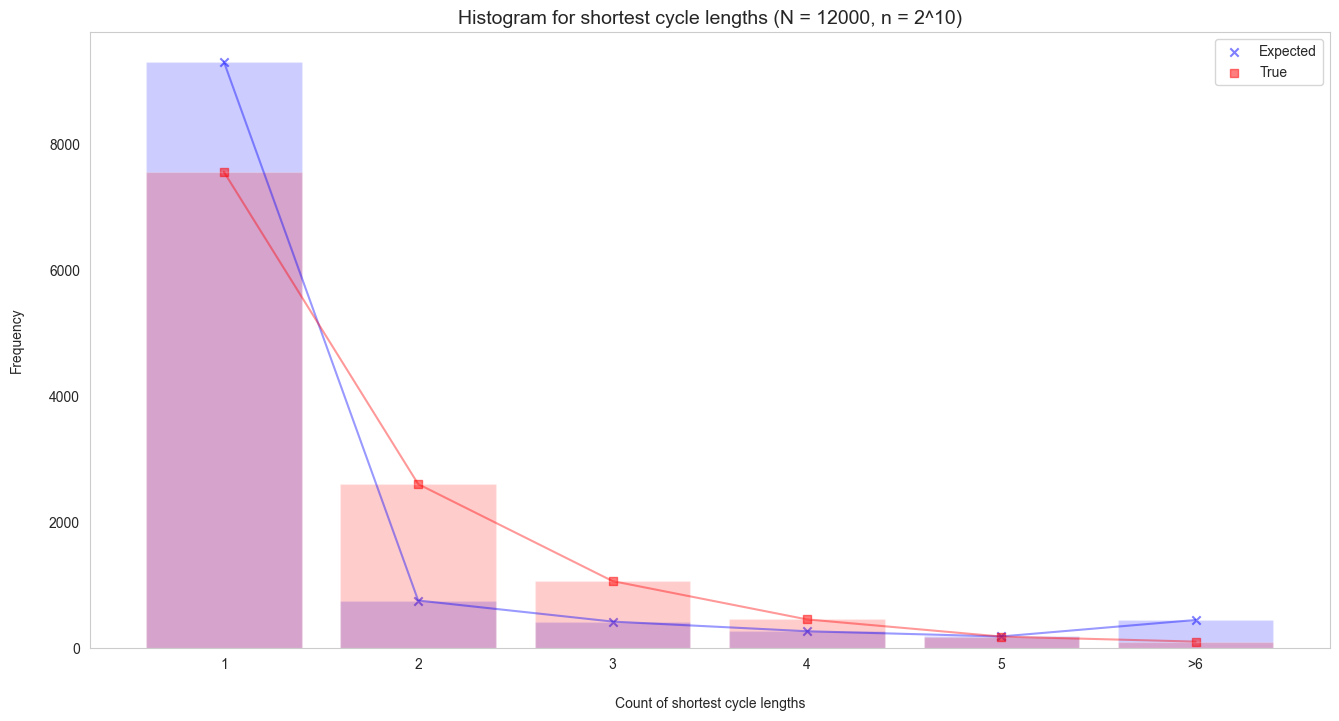

In [1217]:
o_sc_4, e_sc_4 = get_short_cycle_length(permutations_4)
compare_two_distr_graph(o_sc_4, e_sc_4, "shortest cycle lengths")